# Italian sign language recognition from surface EMG and IMU sensors with a deep neural network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/airtlab/italian-sign-language-recognition/blob/master/notebook/Italian_Sign_Language_Recognition_with_EMG_and_IMU_data.ipynb)

This notebook contains the source code of the experiments presented in 
> P. Sernani, I. Pacifici, N. Falcionelli, S. Tomassini, and A.F. Dragoni, *Italian sign language recognition from surface electromyography and inertial measurement unit sensors with a deep neural network*.

a paper submitted for publication at the “4th International Conference Recent Trends and Applications In Computer Science And Information Technology” (RTA-CSIT 2021).

The experiments are **accuracy tests of a deep neural network** based on the Bidirectional Long Short Term Memory (Bi-LSTM) architecture. Such model performs a classification on samples of **EMG and IMU data representing the gestures of the Italian Sign Language** (LIS).

The dataset is publicly available in a dedicated GitHub repository: 
> <https://github.com/airtlab/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet>

### Note

The results presented in the paper are computed with a **GPU runtime**. A total **35 randomized tests on each dataset** were performed, to generalize the performance of the proposed model. Due to the randomization of the dataset splitting and non-deterministic behaviour of GPU computation, the results can slightly change across different runs.

For more information about non-determism on GPU with TensorFlow check <https://github.com/NVIDIA/framework-determinism>.

## 1 Preliminary Operations
The following cells:
- clone the data repository into the **/datarepo** directory;
- define **imports** and some **string costants** used in the notebook;
- define **data augmentation** operations, as the tests were performed on the original data as well as on synthetically augmented data;
- perform the data augmentation, creating an **/AugmentedDataset** directory including both augmented and original data.

In [ ]:
# downloads the dataset with Italian Sign Language samples
!mkdir /datarepo
!git clone https://github.com/airtlab/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet /datarepo

Cloning into '/datarepo'...
remote: Enumerating objects: 901, done.
remote: Counting objects: 100% (901/901), done.
remote: Compressing objects: 100% (862/862), done.
remote: Total 901 (delta 55), reused 883 (delta 39), pack-reused 0
Receiving objects: 100% (901/901), 11.75 MiB | 2.52 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
# notebook imports and string "constants"
import numpy as np

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import models
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import np_utils

from tensorflow.random import set_seed

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

import os
from os import listdir

import json

import shutil 

import random

import math

import datetime

import uuid

from matplotlib import pyplot as plt

import itertools 

# Constants
ORIGINAL_DATA_DIR = '/datarepo/Dataset'
AUGMENTED_DATA_DIR = '/AugmentedDataset'
EMG_FIELD = 'emg'
IMU_FIELD = 'imu'
DURATION_FIELD = 'duration'
FREQUENCY_FIELD = 'frequency'
DATA_FIELD = 'data'
TIMESTAMP_FIELD = 'timestamp'
GYROSCOPE_FIELD = 'gyroscope'
ACCELERATION_FIELD = 'acceleration'
ORIENTATION_FIELD = 'orientation'

In [ ]:
# definition of data augmentation functions

def emg_augmentation(emg, theta):
    """ Rotates an EMG sample of theta degrees.
    
    The rotation is done according to the formulation of Oshahi et al.
    (Augmenting Wearable Sensor Data with Physical Constraint for DNN-Based
    Human-Action Recognition).

    Parameters
    ----------
    emg : list[int]
          8 element length vector with readings from the 8 EMG
          sensors.
    theta : float
            Rotation deegree to apply to the EMG readings.

    Returns
    -------
    new_emg : list[float]
              Rotated 8 element length vector of EMG readings.
    """

    phi = 45 # given by 360/N where N is the number of sensors (8 for the Myo Armband)
    eta = math.floor(theta / phi)
    d = theta / (phi - eta)

    new_emg = []

    for i in range(0, len(emg)):
        if i-eta == 8:
            new_emg.append(( (d**2) * emg[0] + ((1 - d)**2) * emg[i - eta - 1] ) / ( (d**2) + ((1 - d)**2) ))
        else:
            new_emg.append(( (d**2) * emg[i - eta] + ((1 - d)**2) * emg[i - eta - 1] ) / ( (d**2) + ((1 - d)**2) ))
  
    return new_emg


def imu_augmentation(gyr, acc, ori, theta):
    """ Rotates 3D vectors from gyroscope and accelerometer of theta degrees.
    
    It applies a transformation matrix as explained in Oshahi et al. (Augmenting
    Wearable Sensor Data with Physical Constraint for DNN-Based Human-Action 
    Recognition).

    Parameters
    ----------
    gyr : list[float]
          3 element length vector of a gyroscope reading.
    acc : list[float]
          3 element length vector of an accelerometer reading.
    ori : list[float]
          4 element length vector (quaternion) of orientation.
    theta : float
            Rotation deegree to apply to the EMG value.

    Returns
    -------
    new_imu : list[dictionary]
              A list containing a dictionary where "gyroscope" gets the rotated
              gyroscope value,"acceleration" gets the rotated acceleration value,
              and "orientation" is equal to the ori argument.
    """

    theta = math.radians(theta) # deg-rad conversion
    rot_matrix = [[1, 0, 0], [0, math.cos(theta), math.sin(theta)], [0, -math.sin(theta), math.cos(theta)]]

    new_imu = []

    new_gyr = np.dot(rot_matrix, gyr)
    new_acc = np.dot(rot_matrix, acc)

    new_data = { 
        GYROSCOPE_FIELD:  new_gyr.tolist(),
        ACCELERATION_FIELD: new_acc.tolist(),
        ORIENTATION_FIELD: ori
    }
    new_imu.append(new_data)

    return new_imu



def data_augmentation(dataset_path, augmented_dataset_path):
    """ Takes samples from the dataset_path and generates synthetic samples,
    saved in the augmented_dataset_path.

    Parameters
    ----------
    dataset_path : string
                   Path containing folder named as letters ('A', 'B', ...)
                   containing json samples, as described in the dataset
                   specifications of Pacifici et al. (see
                   https://github.com/airtlab/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet).
    augmented_dataset_path : string
                             Destination path for the synthetic samples. It will
                             contain the same folders which are in dataset_path,
                             with new data.
    """

    path = dataset_path
    
    if not os.path.exists(augmented_dataset_path):
        os.makedirs(augmented_dataset_path)

    for gesture in os.listdir(path):
        if not os.path.exists(augmented_dataset_path + '/' + gesture):
            os.makedirs(augmented_dataset_path + '/' + gesture)
        for fil in os.listdir(path + '/' + gesture):
            with open(path + '/' + gesture + '/' + fil, 'r') as f:
                tmp = json.load(f)
            

            sample_number = int(tmp[DURATION_FIELD] / 1000 * int(tmp[EMG_FIELD][FREQUENCY_FIELD]))
            
            gyr = []
            acc = []
            ori = []

            imu = tmp[IMU_FIELD][DATA_FIELD]
            for m in imu:
                gyr.append(m[GYROSCOPE_FIELD])
                acc.append(m[ACCELERATION_FIELD])
                ori.append(m[ORIENTATION_FIELD])

            k = [-4, -3, -2, -1, 1, 2, 3, 4] 
            for e in k:
                new_emg = []
                new_imu = []
                for i in range(0, sample_number):
                    new_emg.append(emg_augmentation(tmp[EMG_FIELD][DATA_FIELD][i], 7.5*e))
                    new_imu.append(imu_augmentation(gyr[i], acc[i], ori[i], 7.5*e)[0])

                

                data = {
                    TIMESTAMP_FIELD: e,
                    DURATION_FIELD: tmp[DURATION_FIELD],
                    EMG_FIELD: {
                        FREQUENCY_FIELD: tmp[EMG_FIELD][FREQUENCY_FIELD],
                        DATA_FIELD: new_emg
                    },
                    IMU_FIELD: {
                        FREQUENCY_FIELD: tmp[IMU_FIELD][FREQUENCY_FIELD],
                        DATA_FIELD: new_imu
                    }
                }

                filename = str(uuid.uuid4()) # use this to name augmented file with uuid
                
                filepath = augmented_dataset_path + '/' + gesture + '/' + filename + '.json'

                with open(filepath, 'w') as f:
                    json.dump(data, f)

def copy_original_files(dataset_path, augmented_dataset_path):
    """ Copies the original file into the augmented dataset.
    
    It copies all the files included in the folders at dataset_path, in the same folders
    in augmented_dataset_path.

    Parameters
    ----------
    dataset_path : string
                   Path containing 26 folders named as letters ('A', 'B', ...)
                   containing json samples, as described in the dataset
                   specifications of Pacifici et al. (see
                   https://github.com/airtlab/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet)
    augmented_dataset_path : string
                             Destination path for the copied files
    """

    for gesture in os.listdir(dataset_path):
        for fil in os.listdir(dataset_path + '/' + gesture):
            shutil.copyfile((dataset_path + '/' + gesture + '/' + fil), (augmented_dataset_path + '/' + gesture + '/' + fil))  


In [ ]:
# Creates the augmented dataset and copies there also the original data
data_augmentation(ORIGINAL_DATA_DIR, AUGMENTED_DATA_DIR)
copy_original_files(ORIGINAL_DATA_DIR, AUGMENTED_DATA_DIR)

## 2 Experiments
The following cells:
- define the class which implements the **neural network architecture** and the methods to organize samples and labels for training and test purposes;
- run **four experiments**, two on the **original dataset** and two on the **augmented dataset**.

### 2.1 Neural Network Architecture
The layers of the neural network are listed in the following table.

| Layer Type                                     | Output Shape     | Parameter # |
|------------------------------------------------|:----------------:|-------------:|
| Bi-LSTM, *64 hidden units*, *return sequences* | (None, 400, 128) |       40448 |
| Bi-LSTM, *32 hidden units*                     | (None, 64)       |       41216 |
| Dropout, *0.5*                                 | (None, 64)       |           0 |
| Dense, *64 hidden units*, *ReLU activation*    | (None, 64)       |        4160 |
| Dropout, *0.5*                                 | (None, 64)       |           0 |
| Dense, *26 hidden units*, *Softmax activation* | (None, 26)       |        1690 |

The loss function is the **categorical cross entropy**, while the optimization is done with the **Root Mean Square Propagation** (RMSProp). The training was **early stopped** after 5 epochs without any improvement on the minimal validation loss found.

### 2.2 Tests
The test results are cross-validated with a **Stratified Shuffle Split** strategy. Both the original and augmented datasets are randomly split using the 80% of data for training and the 20% for testing. 12.5% of training data (equal to the 10% of the entire dataset) are used for validation. In other words, **70% of the data are used for training, 10% for validation and 20% for testing**.

Four experiments are executed:
- the experiment **number 1** runs the stratified shuffle split **5 times** on the **original dataset**, printing training epochs, the classification report and the confusion matrix for each split;
- the experiment **number 2** runs the stratified shuffle split **5 times** on the **augmented dataset**, printing training epochs, the classification report and the confusion matrix for each split;
- the experiment **number 3** runs the stratified shuffle split **30 times** on the **original dataset**, printing training epochs, the classification report and the confusion matrix for each split;
- the experiment **number 4** runs the stratified shuffle split **30 times** on the **augmented dataset**, printing training epochs, the classification report and the confusion matrix for each split.

In [ ]:
# network and training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 300
PATIENCE = 5
HIDDEN_UNITS = 64

class BidirectionalLSTMGestureClassifier(object):
    """ Bi-LSTM-based gesture classifier

    ...

    Attributes
    ----------
    model : Sequential
        Sequential model to perform the classification

    Methods
    -------
    create_model(self, printSummary):
        Creates the sequential model.

    instantiate_new_model(self, printSummary):
        Deletes the previously instantieted model, if any, and create a new one.

    create_sample(self, jsonSample):
        Creates a sample array for the classifier.

    create_samples_labels(self, dataset_path):
        Creates the arrays with all samples and labels for the classifier.
    
    runExperiment(self, dataset_path, random_state=None):
        Launches a classification experiment.
    """

    def __init__(self):
        self.model = None

    def create_model(self, printSummary):
        """ Creates the sequential model of the classifier.

        Parameters
        ----------
        printSummary : bool
                       If True, prints the model summary.
        """

        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(units=HIDDEN_UNITS, return_sequences=True), input_shape=(400, 14), name='blstm1')) 
        self.model.add(Bidirectional(LSTM(32), name='blstm2'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(64, activation='relu', name='fc1'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(26, activation='softmax', name='fc2'))
        
        rmsprop = optimizers.RMSprop(lr=0.001)
        
        self.model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

        if printSummary:
            self.model.summary()

        return self.model

    def instantiate_new_model(self, printSummary):
        """ Deletes the existing sequential model, if any and creates a new one.

        Parameters
        ----------
        printSummary : bool
                       If True, prints the model summary.
        """

        if self.model:
            del self.model
        self.create_model(printSummary)


    def create_sample(self, jsonSample):
        """ Creates a sample array for the classifier with EMG and IMU data.

        Parameters
        ----------
        jsonSample : dict
                     Deserialized json sample, with json.load().

        Returns
        -------
        x2 : numpy.ndarray
             Sample array of shape (Sample frequency * 2, number of features)
             representing a sample. It should be 400 x 14 as a gesture feature
             are 8 EMG reading + gyroscope (3D vector) + acceleration (3D vector)
             = 14, sampled at 200Hz for 2 seconds (400).
        """

        x1 = []
        emg = []
        gyr = []
        acc = []
        ori = []


        sample_number = int(jsonSample[DURATION_FIELD] / 1000 * int(jsonSample[EMG_FIELD][FREQUENCY_FIELD]))
        for k in range(0, sample_number):
            emg.append(jsonSample[EMG_FIELD][DATA_FIELD][k])

            
        imu = jsonSample[IMU_FIELD][DATA_FIELD]
        for m in imu:
            gyr.append(m[GYROSCOPE_FIELD])
            acc.append(m[ACCELERATION_FIELD])
            #ori.append(m["orientation"]) # uncomment to load also the orientation field (unused in the current experiments)

        for i in range(0, len(emg)):
            x = [emg[i], gyr[i], acc[i]]
        
            flat = []
            for sublist in x:
                for item in sublist:
                    flat.append(item)

            x1.append(flat)
        
        
        x2 = np.array(x1)
        return x2


    def create_samples_labels(self, dataset_path):
        """ Creates the lists with samples and labels for the classifier.

        Parameters
        ----------
        dataset_path : string
                       Path containing 26 class folders named as the letters
                       ('A', 'B', etc.); each folder include the json files with
                       all the samplee for that class.

        Returns
        -------
        x_samples : list[numpy.ndarray]
                    List of all the samples contained in the dataset.
        y_labels : list[int]
                   Class labels for the samples in x_samples.
        """

        path = dataset_path 

        x_samples = []
        y_samples = []

        i = 0
        for gesture in os.listdir(path):
            j = 0
            for fil in os.listdir(path + '/' + gesture):
              y = gesture
              y_samples.append(y)

              with open(path + '/' + gesture + '/' + fil, 'r') as f:
                  tmp = json.load(f)
              
              x = self.create_sample(tmp)
              x_samples.append(x)

              j = j + 1

        i = i + 1

        return x_samples, y_samples



    def runExperiment(self, dataset_path, split_number=5, print_report=True):
        """ Launches a classifier test, with 5 stratified shuffled splits, with
        70% of data for training, 10% for validation, 20% for test.

        Parameters
        ----------
        dataset_path : string
                       Path containing 26 class folders named as the letters
                       ('A', 'B', etc.); each folder include the json files with
                       all the samplee for that class.
        split_number : int
                       Number of split to run the Stratified Shuffle Split
                       (default 5).
        print_report : bool
                       If True, the method prints classification the
                       classification and the confusion matrix (default True).
        """

        # get samples and labels
        samples, y_samples = self.create_samples_labels(dataset_path) ###############

        x_samples = np.array(samples)

        
        # makes the labels numerical using characters' ASCII code. In this way, A gets 0 as the label, B 1, C 2 and so on...
        for i, label in enumerate(y_samples):
            y_samples[i] = ord(label) - ord('A')


        # makes y_samples a categorical matrix
        y_samples = np_utils.to_categorical(y_samples, 26)

        nsplits = split_number
        #cv = StratifiedKFold(n_splits=nsplits, shuffle=True)
        cv = StratifiedShuffleSplit(n_splits=nsplits, train_size=0.8)

        scores = []
        i = 1
        classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

        for train, test in cv.split(x_samples, y_samples):

            self.instantiate_new_model(i == 1)
            es = EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, verbose=1, restore_best_weights=True)
            self.model.fit(x_samples[train], y_samples[train], validation_split=0.125, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[es], shuffle=True)

            print('Evaluating...')
            eval = self.model.evaluate(x_samples[test], y_samples[test])
            scores.append(eval)
            print ('Loss: ' + str(eval[0]) + ' ' + 'Acc: ' + str(eval[1]))
                   
            print('Predicting labels...')
            pred = self.model.predict(x_samples[test])
            y_true = y_samples[test].argmax(axis=-1)
            y_pred = pred.argmax(axis=-1)

            if print_report:
                print(classification_report(y_true, y_pred, target_names=classes))
                plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=classes, file_path='')

            i = i + 1

        np_scores = np.array(scores)
        losses = np_scores[:, 0:1]
        accuracies = np_scores[:, 1:2]
        print('Losses')
        print(losses)
        print('Accuracies')
        print(accuracies)
        print("Avg loss: {0} +/- {1}".format(np.mean(losses), np.std(losses)))
        print("Avg accuracy: {0} +/- {1}".format(np.mean(accuracies), np.std(accuracies)))

def plot_confusion_matrix(cm, classes, file_path, title='Confusion matrix', cmap=plt.cm.Blues):

    """ Plots the confusion matrix.
    
    If the file_path is not empty, it saves the plot at that specific path

    Parameters
    ----------
    cm : numpy.ndarray
         Ndarray of shape (n_classes, n_classes) which is the confusion matrix
         whose i-th row and j-th column entry indicates the number of samples
         with true label being i-th class and predicted label being j-th class.
    classes : list[string]
              List of the class names.
    file_path : string
                File path to save the plot.
    title : string
            The plot title.
    cmap : string or matplotlib Colormap
           Colormap recognized by matplotlib.
    """ 

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes) 
 
    thresh = cm.max() / 2. 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j, i, cm[i, j], 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black") 
 
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.show() 

    if file_path:
        plt.savefig(file_path)        



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
blstm1 (Bidirectional)       (None, 400, 128)          40448     
_________________________________________________________________
blstm2 (Bidirectional)       (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 26)                1690      
Total params: 87,514
Trainable params: 87,514
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           A       0.57      0.67      0.62         6
           B       0.50      0.50      0.50         6
           C       0.57      0.67      0.62         6
           D       0.67      0.33      0.44         6
           E       0.50      0.50      0.50         6
           F       0.75      0.50      0.60         6
           G       0.62      0.83      0.71         6
           H       0.00      0.00      0.00         6
           I       0.33      0.50      0.40         6
           J       1.00      0.50      0.67         6
           K       0.40      0.67      0.50         6
           L       1.00      0.83      0.91         6
           M       0.00      0.00      0.00         6
           N       0.40      0.67      0.50         6
           O       0.57      0.67      0.62         6
           P       0.33      0.33      0.33         6
           Q       0.86      1.00      0.92         6
           R       1.00    

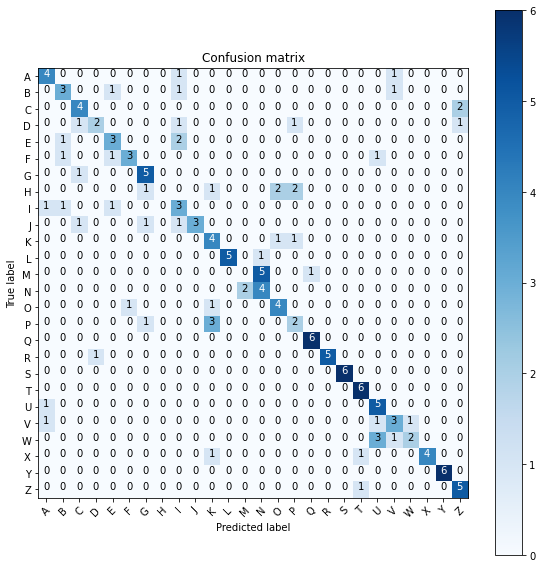

Epoch 1/300
18/18 [==============================] - 8s 152ms/step - loss: 3.2544 - accuracy: 0.0576 - val_loss: 3.1581 - val_accuracy: 0.1026
Epoch 2/300
18/18 [==============================] - 1s 68ms/step - loss: 3.1713 - accuracy: 0.0538 - val_loss: 3.1005 - val_accuracy: 0.1538
Epoch 3/300
18/18 [==============================] - 1s 69ms/step - loss: 3.1003 - accuracy: 0.1216 - val_loss: 3.0113 - val_accuracy: 0.1410
Epoch 4/300
18/18 [==============================] - 1s 68ms/step - loss: 3.0497 - accuracy: 0.1351 - val_loss: 2.9653 - val_accuracy: 0.1667
Epoch 5/300
18/18 [==============================] - 1s 68ms/step - loss: 2.9065 - accuracy: 0.1897 - val_loss: 2.8473 - val_accuracy: 0.1795
Epoch 6/300
18/18 [==============================] - 1s 67ms/step - loss: 2.8999 - accuracy: 0.1688 - val_loss: 2.7214 - val_accuracy: 0.2308
Epoch 7/300
18/18 [==============================] - 1s 68ms/step - loss: 2.7258 - accuracy: 0.1858 - val_loss: 2.6397 - val_accuracy: 0.1795
Epoch

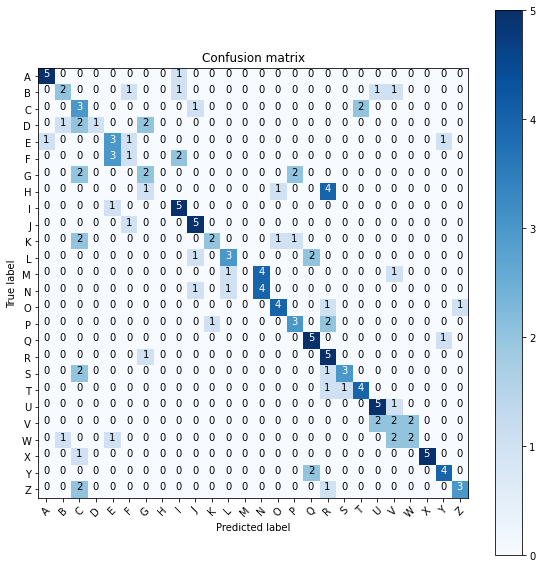

Epoch 1/300
18/18 [==============================] - 8s 171ms/step - loss: 3.3022 - accuracy: 0.0483 - val_loss: 3.2094 - val_accuracy: 0.0641
Epoch 2/300
18/18 [==============================] - 1s 70ms/step - loss: 3.1580 - accuracy: 0.0864 - val_loss: 3.1031 - val_accuracy: 0.1154
Epoch 3/300
18/18 [==============================] - 1s 71ms/step - loss: 3.0811 - accuracy: 0.1030 - val_loss: 3.0054 - val_accuracy: 0.1026
Epoch 4/300
18/18 [==============================] - 1s 71ms/step - loss: 2.9777 - accuracy: 0.1171 - val_loss: 2.9477 - val_accuracy: 0.1282
Epoch 5/300
18/18 [==============================] - 1s 72ms/step - loss: 2.9073 - accuracy: 0.1300 - val_loss: 2.8305 - val_accuracy: 0.1795
Epoch 6/300
18/18 [==============================] - 1s 73ms/step - loss: 2.7747 - accuracy: 0.1589 - val_loss: 2.6646 - val_accuracy: 0.2308
Epoch 7/300
18/18 [==============================] - 1s 72ms/step - loss: 2.6961 - accuracy: 0.1966 - val_loss: 2.5834 - val_accuracy: 0.2692
Epoch

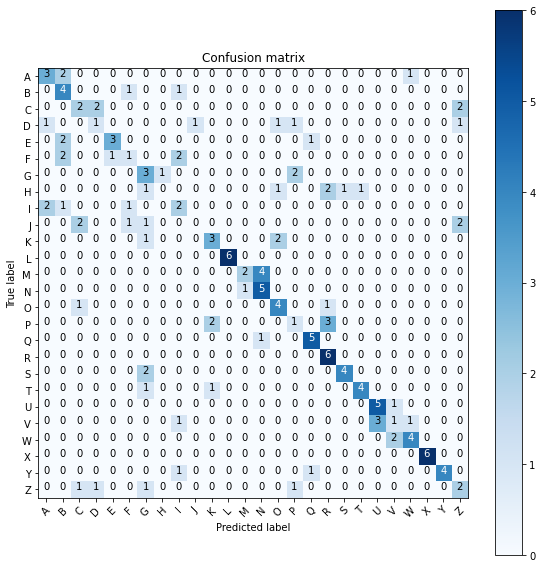

Epoch 1/300
18/18 [==============================] - 8s 146ms/step - loss: 3.2492 - accuracy: 0.0569 - val_loss: 3.1957 - val_accuracy: 0.1282
Epoch 2/300
18/18 [==============================] - 1s 70ms/step - loss: 3.1912 - accuracy: 0.0569 - val_loss: 3.1350 - val_accuracy: 0.1667
Epoch 3/300
18/18 [==============================] - 1s 70ms/step - loss: 3.1392 - accuracy: 0.0596 - val_loss: 3.0513 - val_accuracy: 0.1667
Epoch 4/300
18/18 [==============================] - 1s 71ms/step - loss: 2.9657 - accuracy: 0.1610 - val_loss: 2.9503 - val_accuracy: 0.1538
Epoch 5/300
18/18 [==============================] - 1s 70ms/step - loss: 2.8546 - accuracy: 0.1185 - val_loss: 2.8434 - val_accuracy: 0.1795
Epoch 6/300
18/18 [==============================] - 1s 71ms/step - loss: 2.7331 - accuracy: 0.1922 - val_loss: 2.7657 - val_accuracy: 0.1667
Epoch 7/300
18/18 [==============================] - 1s 70ms/step - loss: 2.6566 - accuracy: 0.1790 - val_loss: 2.6601 - val_accuracy: 0.2308
Epoch

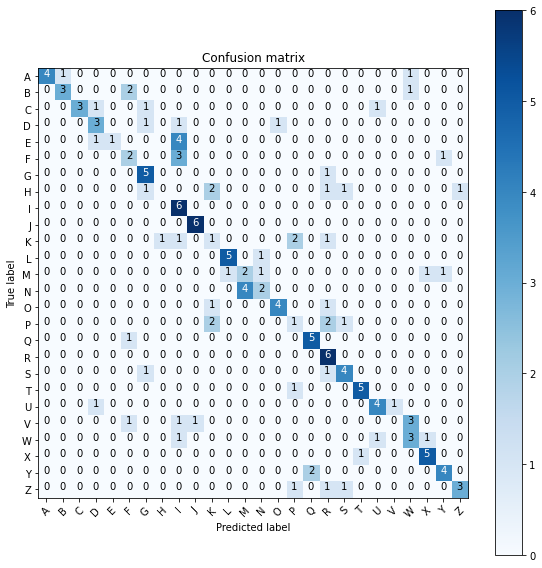

Epoch 1/300
18/18 [==============================] - 8s 146ms/step - loss: 3.2978 - accuracy: 0.0445 - val_loss: 3.1867 - val_accuracy: 0.0641
Epoch 2/300
18/18 [==============================] - 1s 70ms/step - loss: 3.2148 - accuracy: 0.0586 - val_loss: 3.1161 - val_accuracy: 0.1667
Epoch 3/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1463 - accuracy: 0.1170 - val_loss: 3.0412 - val_accuracy: 0.1795
Epoch 4/300
18/18 [==============================] - 1s 70ms/step - loss: 3.0696 - accuracy: 0.1041 - val_loss: 2.9436 - val_accuracy: 0.1538
Epoch 5/300
18/18 [==============================] - 1s 71ms/step - loss: 2.9735 - accuracy: 0.1406 - val_loss: 2.9028 - val_accuracy: 0.2179
Epoch 6/300
18/18 [==============================] - 1s 71ms/step - loss: 2.8725 - accuracy: 0.1789 - val_loss: 2.6986 - val_accuracy: 0.2692
Epoch 7/300
18/18 [==============================] - 1s 80ms/step - loss: 2.7909 - accuracy: 0.1309 - val_loss: 2.6366 - val_accuracy: 0.3205
Epoch

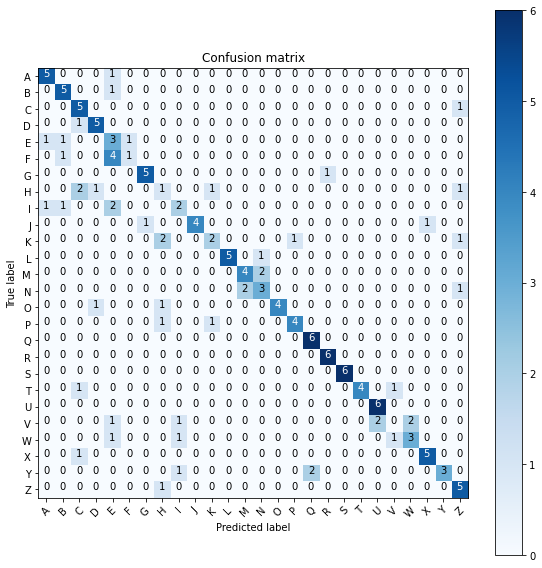

Losses
[[1.06152463]
 [1.56974792]
 [1.34470916]
 [1.3818295 ]
 [1.03650784]]
Accuracies
[[0.62179488]
 [0.51923078]
 [0.51923078]
 [0.55769229]
 [0.65384614]]
Avg loss: 1.2788638114929198 +/- 0.20274311065832273
Avg accuracy: 0.5743589758872986 +/- 0.054634034617354894


In [ ]:
# Experiment 1: training and test on the original dataset, 5 random splits
model = BidirectionalLSTMGestureClassifier()
model.runExperiment(dataset_path=ORIGINAL_DATA_DIR, split_number=5, print_report=True)


del model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
blstm1 (Bidirectional)       (None, 400, 128)          40448     
_________________________________________________________________
blstm2 (Bidirectional)       (None, 64)                41216     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 26)                1690      
Total params: 87,514
Trainable params: 87,514
Non-trainable params: 0
__________________________________________________

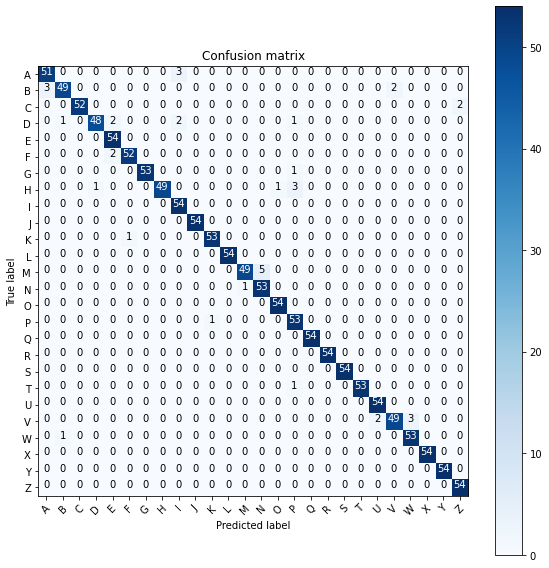

Epoch 1/300
154/154 [==============================] - 20s 87ms/step - loss: 3.1751 - accuracy: 0.0822 - val_loss: 2.5079 - val_accuracy: 0.3575
Epoch 2/300
154/154 [==============================] - 12s 77ms/step - loss: 2.5346 - accuracy: 0.2419 - val_loss: 1.8742 - val_accuracy: 0.4459
Epoch 3/300
154/154 [==============================] - 12s 78ms/step - loss: 2.1066 - accuracy: 0.3218 - val_loss: 1.4817 - val_accuracy: 0.5513
Epoch 4/300
154/154 [==============================] - 12s 78ms/step - loss: 1.8151 - accuracy: 0.3903 - val_loss: 1.2455 - val_accuracy: 0.6296
Epoch 5/300
154/154 [==============================] - 12s 78ms/step - loss: 1.5999 - accuracy: 0.4604 - val_loss: 1.1796 - val_accuracy: 0.6481
Epoch 6/300
154/154 [==============================] - 12s 78ms/step - loss: 1.4470 - accuracy: 0.5096 - val_loss: 1.0890 - val_accuracy: 0.6353
Epoch 7/300
154/154 [==============================] - 12s 77ms/step - loss: 1.3243 - accuracy: 0.5360 - val_loss: 0.9115 - val_ac

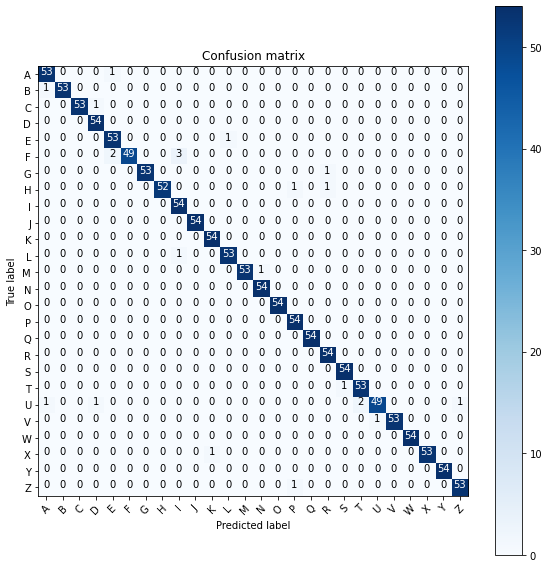

Epoch 1/300
154/154 [==============================] - 20s 89ms/step - loss: 3.2061 - accuracy: 0.0732 - val_loss: 2.5779 - val_accuracy: 0.2963
Epoch 2/300
154/154 [==============================] - 12s 80ms/step - loss: 2.5930 - accuracy: 0.2185 - val_loss: 1.8060 - val_accuracy: 0.4915
Epoch 3/300
154/154 [==============================] - 12s 79ms/step - loss: 2.0677 - accuracy: 0.3391 - val_loss: 1.4514 - val_accuracy: 0.5342
Epoch 4/300
154/154 [==============================] - 12s 80ms/step - loss: 1.7588 - accuracy: 0.4047 - val_loss: 1.3061 - val_accuracy: 0.5855
Epoch 5/300
154/154 [==============================] - 12s 80ms/step - loss: 1.5560 - accuracy: 0.4831 - val_loss: 1.0817 - val_accuracy: 0.6581
Epoch 6/300
154/154 [==============================] - 12s 79ms/step - loss: 1.3522 - accuracy: 0.5583 - val_loss: 0.9386 - val_accuracy: 0.6752
Epoch 7/300
154/154 [==============================] - 12s 80ms/step - loss: 1.2821 - accuracy: 0.5609 - val_loss: 0.9187 - val_ac

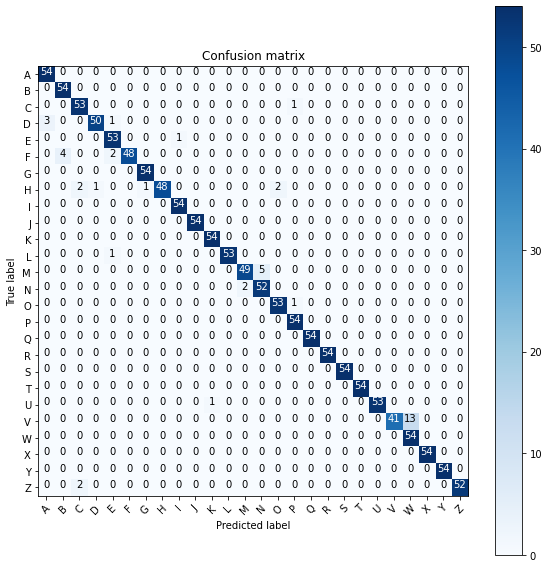

Epoch 1/300
154/154 [==============================] - 20s 90ms/step - loss: 3.1708 - accuracy: 0.0792 - val_loss: 2.5129 - val_accuracy: 0.3034
Epoch 2/300
154/154 [==============================] - 12s 81ms/step - loss: 2.5433 - accuracy: 0.2228 - val_loss: 1.8246 - val_accuracy: 0.4473
Epoch 3/300
154/154 [==============================] - 12s 80ms/step - loss: 2.0870 - accuracy: 0.3346 - val_loss: 1.5037 - val_accuracy: 0.5085
Epoch 4/300
154/154 [==============================] - 12s 81ms/step - loss: 1.8079 - accuracy: 0.4039 - val_loss: 1.2793 - val_accuracy: 0.6197
Epoch 5/300
154/154 [==============================] - 12s 80ms/step - loss: 1.5720 - accuracy: 0.4658 - val_loss: 1.0926 - val_accuracy: 0.6652
Epoch 6/300
154/154 [==============================] - 12s 81ms/step - loss: 1.4308 - accuracy: 0.5244 - val_loss: 0.9537 - val_accuracy: 0.6980
Epoch 7/300
154/154 [==============================] - 12s 81ms/step - loss: 1.3066 - accuracy: 0.5626 - val_loss: 0.8718 - val_ac

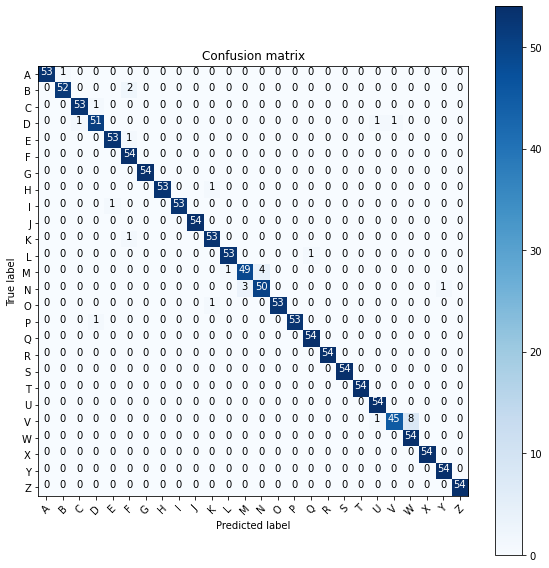

Epoch 1/300
154/154 [==============================] - 20s 90ms/step - loss: 3.1455 - accuracy: 0.0854 - val_loss: 2.3293 - val_accuracy: 0.3262
Epoch 2/300
154/154 [==============================] - 13s 81ms/step - loss: 2.4833 - accuracy: 0.2189 - val_loss: 1.7910 - val_accuracy: 0.4302
Epoch 3/300
154/154 [==============================] - 12s 81ms/step - loss: 2.0391 - accuracy: 0.3347 - val_loss: 1.5187 - val_accuracy: 0.5071
Epoch 4/300
154/154 [==============================] - 12s 81ms/step - loss: 1.7518 - accuracy: 0.3962 - val_loss: 1.2784 - val_accuracy: 0.5698
Epoch 5/300
154/154 [==============================] - 12s 81ms/step - loss: 1.5600 - accuracy: 0.4700 - val_loss: 1.1078 - val_accuracy: 0.6510
Epoch 6/300
154/154 [==============================] - 12s 81ms/step - loss: 1.3873 - accuracy: 0.5260 - val_loss: 1.1182 - val_accuracy: 0.6011
Epoch 7/300
154/154 [==============================] - 12s 80ms/step - loss: 1.3250 - accuracy: 0.5414 - val_loss: 0.9661 - val_ac

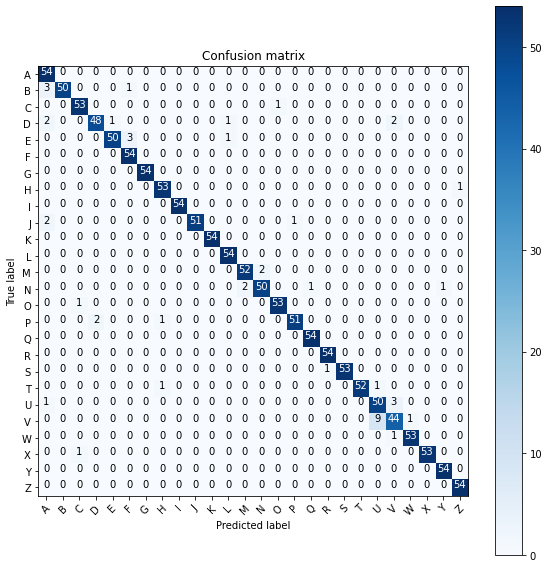

Losses
[[0.07323381]
 [0.0753037 ]
 [0.08887274]
 [0.06680597]
 [0.13594078]]
Accuracies
[[0.97222221]
 [0.98361826]
 [0.96937323]
 [0.97720796]
 [0.96581197]]
Avg loss: 0.08803139626979828 +/- 0.02500999150761362
Avg accuracy: 0.9736467242240906 +/- 0.006225581774121474


In [ ]:
# Experiment 2: training and test on the augmented dataset, 5 random splits
model = BidirectionalLSTMGestureClassifier()
model.runExperiment(dataset_path=AUGMENTED_DATA_DIR, split_number=5, print_report=True)

del model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
blstm1 (Bidirectional)       (None, 400, 128)          40448     
_________________________________________________________________
blstm2 (Bidirectional)       (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 26)                1690      
Total params: 87,514
Trainable params: 87,514
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           A       0.80      0.67      0.73         6
           B       0.67      0.33      0.44         6
           C       0.75      0.50      0.60         6
           D       0.67      0.67      0.67         6
           E       0.60      0.50      0.55         6
           F       0.38      0.50      0.43         6
           G       0.67      0.67      0.67         6
           H       0.00      0.00      0.00         6
           I       0.38      0.50      0.43         6
           J       1.00      0.83      0.91         6
           K       0.00      0.00      0.00         6
           L       1.00      0.83      0.91         6
           M       0.67      1.00      0.80         6
           N       1.00      0.67      0.80         6
           O       0.50      0.83      0.62         6
           P       0.50      0.67      0.57         6
           Q       0.55      1.00      0.71         6
           R       0.86    

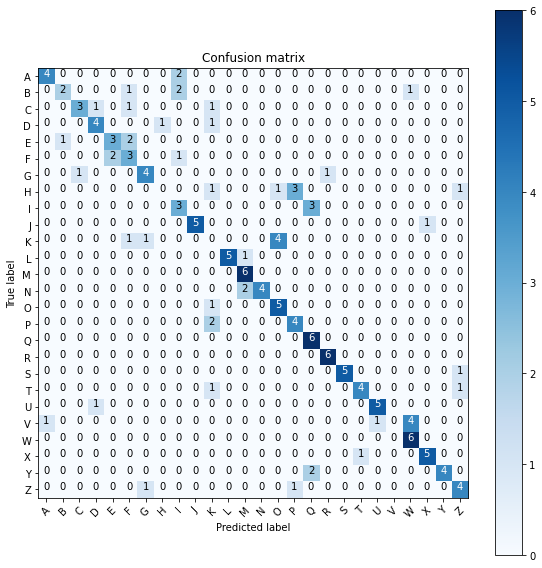

Epoch 1/300
18/18 [==============================] - 7s 151ms/step - loss: 3.2399 - accuracy: 0.0603 - val_loss: 3.1666 - val_accuracy: 0.1538
Epoch 2/300
18/18 [==============================] - 1s 62ms/step - loss: 3.1343 - accuracy: 0.1054 - val_loss: 3.0649 - val_accuracy: 0.1154
Epoch 3/300
18/18 [==============================] - 1s 61ms/step - loss: 3.1007 - accuracy: 0.0760 - val_loss: 2.9918 - val_accuracy: 0.1410
Epoch 4/300
18/18 [==============================] - 1s 62ms/step - loss: 2.9729 - accuracy: 0.1310 - val_loss: 2.9558 - val_accuracy: 0.1410
Epoch 5/300
18/18 [==============================] - 1s 61ms/step - loss: 2.8560 - accuracy: 0.1877 - val_loss: 2.7695 - val_accuracy: 0.1026
Epoch 6/300
18/18 [==============================] - 1s 61ms/step - loss: 2.6722 - accuracy: 0.1824 - val_loss: 2.6685 - val_accuracy: 0.1795
Epoch 7/300
18/18 [==============================] - 1s 62ms/step - loss: 2.6193 - accuracy: 0.1782 - val_loss: 2.6466 - val_accuracy: 0.1154
Epoch

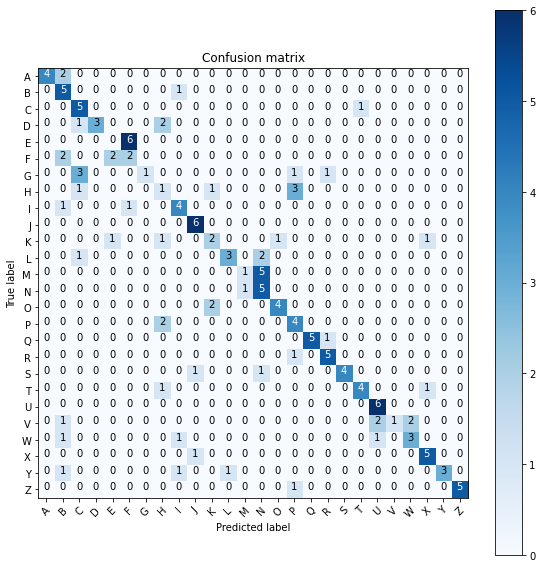

Epoch 1/300
18/18 [==============================] - 7s 130ms/step - loss: 3.2566 - accuracy: 0.0554 - val_loss: 3.1958 - val_accuracy: 0.0385
Epoch 2/300
18/18 [==============================] - 1s 63ms/step - loss: 3.1541 - accuracy: 0.0589 - val_loss: 3.1129 - val_accuracy: 0.0897
Epoch 3/300
18/18 [==============================] - 1s 62ms/step - loss: 3.1343 - accuracy: 0.0996 - val_loss: 3.0164 - val_accuracy: 0.1282
Epoch 4/300
18/18 [==============================] - 1s 61ms/step - loss: 2.9967 - accuracy: 0.1392 - val_loss: 2.9481 - val_accuracy: 0.2051
Epoch 5/300
18/18 [==============================] - 1s 63ms/step - loss: 2.8981 - accuracy: 0.1602 - val_loss: 2.8444 - val_accuracy: 0.1923
Epoch 6/300
18/18 [==============================] - 1s 64ms/step - loss: 2.8090 - accuracy: 0.1651 - val_loss: 2.6479 - val_accuracy: 0.2692
Epoch 7/300
18/18 [==============================] - 1s 62ms/step - loss: 2.6878 - accuracy: 0.2202 - val_loss: 2.6249 - val_accuracy: 0.3333
Epoch

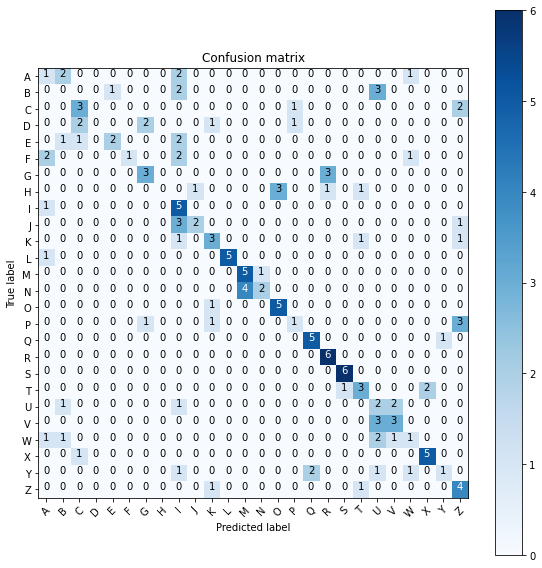

Epoch 1/300
18/18 [==============================] - 7s 138ms/step - loss: 3.2974 - accuracy: 0.0615 - val_loss: 3.2098 - val_accuracy: 0.0641
Epoch 2/300
18/18 [==============================] - 1s 64ms/step - loss: 3.2081 - accuracy: 0.0833 - val_loss: 3.1524 - val_accuracy: 0.1282
Epoch 3/300
18/18 [==============================] - 1s 65ms/step - loss: 3.1165 - accuracy: 0.0927 - val_loss: 3.0748 - val_accuracy: 0.1410
Epoch 4/300
18/18 [==============================] - 1s 63ms/step - loss: 3.0662 - accuracy: 0.1367 - val_loss: 2.9824 - val_accuracy: 0.1795
Epoch 5/300
18/18 [==============================] - 1s 64ms/step - loss: 3.0156 - accuracy: 0.1250 - val_loss: 2.8668 - val_accuracy: 0.2179
Epoch 6/300
18/18 [==============================] - 1s 63ms/step - loss: 2.8876 - accuracy: 0.1410 - val_loss: 2.7012 - val_accuracy: 0.2051
Epoch 7/300
18/18 [==============================] - 1s 63ms/step - loss: 2.7474 - accuracy: 0.1832 - val_loss: 2.5526 - val_accuracy: 0.2949
Epoch

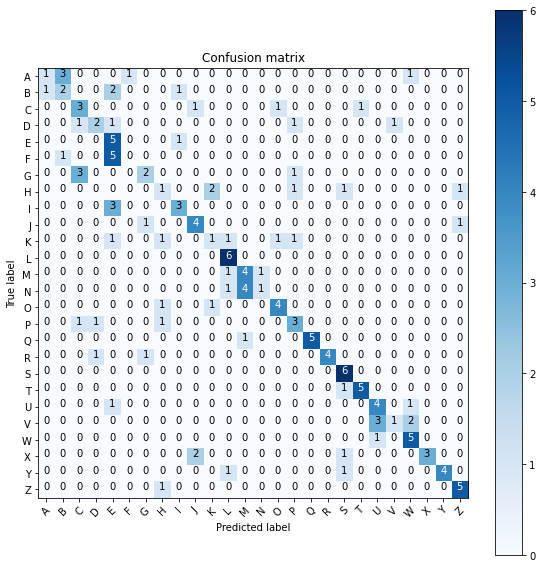

Epoch 1/300
18/18 [==============================] - 7s 133ms/step - loss: 3.2664 - accuracy: 0.0384 - val_loss: 3.2097 - val_accuracy: 0.1026
Epoch 2/300
18/18 [==============================] - 1s 64ms/step - loss: 3.1705 - accuracy: 0.0742 - val_loss: 3.1615 - val_accuracy: 0.1282
Epoch 3/300
18/18 [==============================] - 1s 63ms/step - loss: 3.1010 - accuracy: 0.1179 - val_loss: 3.0615 - val_accuracy: 0.1538
Epoch 4/300
18/18 [==============================] - 1s 64ms/step - loss: 3.0346 - accuracy: 0.1139 - val_loss: 2.9668 - val_accuracy: 0.2179
Epoch 5/300
18/18 [==============================] - 1s 64ms/step - loss: 2.9280 - accuracy: 0.1232 - val_loss: 2.8348 - val_accuracy: 0.2436
Epoch 6/300
18/18 [==============================] - 1s 64ms/step - loss: 2.8343 - accuracy: 0.1878 - val_loss: 2.7284 - val_accuracy: 0.2436
Epoch 7/300
18/18 [==============================] - 1s 64ms/step - loss: 2.7474 - accuracy: 0.2258 - val_loss: 2.6090 - val_accuracy: 0.2692
Epoch

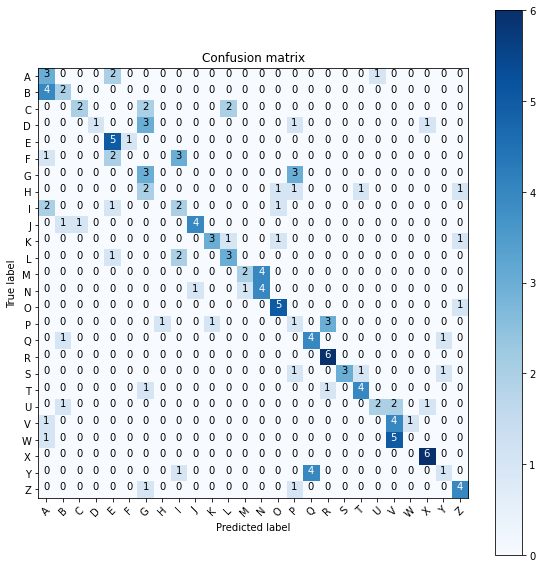

Epoch 1/300
18/18 [==============================] - 7s 155ms/step - loss: 3.2874 - accuracy: 0.0396 - val_loss: 3.1999 - val_accuracy: 0.1026
Epoch 2/300
18/18 [==============================] - 1s 64ms/step - loss: 3.2269 - accuracy: 0.0493 - val_loss: 3.2007 - val_accuracy: 0.1538
Epoch 3/300
18/18 [==============================] - 1s 64ms/step - loss: 3.1630 - accuracy: 0.0837 - val_loss: 3.1093 - val_accuracy: 0.1923
Epoch 4/300
18/18 [==============================] - 1s 64ms/step - loss: 3.1338 - accuracy: 0.0905 - val_loss: 3.0311 - val_accuracy: 0.1667
Epoch 5/300
18/18 [==============================] - 1s 64ms/step - loss: 2.9937 - accuracy: 0.1403 - val_loss: 2.9129 - val_accuracy: 0.2564
Epoch 6/300
18/18 [==============================] - 1s 66ms/step - loss: 2.8865 - accuracy: 0.1609 - val_loss: 2.8229 - val_accuracy: 0.1923
Epoch 7/300
18/18 [==============================] - 1s 63ms/step - loss: 2.8318 - accuracy: 0.2191 - val_loss: 2.7153 - val_accuracy: 0.2821
Epoch

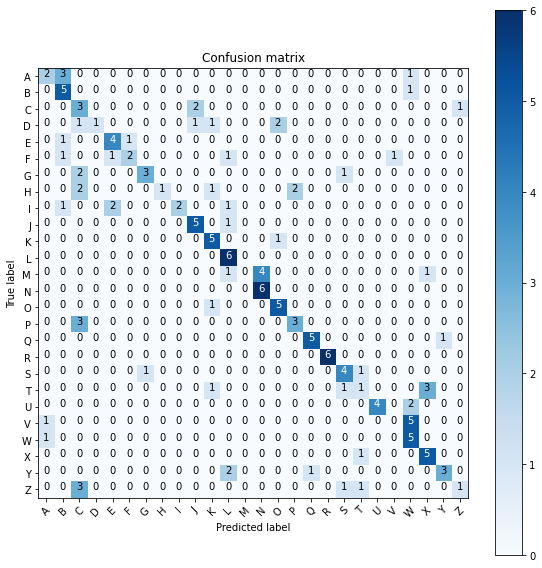

Epoch 1/300
18/18 [==============================] - 7s 131ms/step - loss: 3.2727 - accuracy: 0.0774 - val_loss: 3.1911 - val_accuracy: 0.0641
Epoch 2/300
18/18 [==============================] - 1s 65ms/step - loss: 3.1684 - accuracy: 0.0789 - val_loss: 3.0971 - val_accuracy: 0.1923
Epoch 3/300
18/18 [==============================] - 1s 65ms/step - loss: 3.0488 - accuracy: 0.1076 - val_loss: 2.9972 - val_accuracy: 0.2564
Epoch 4/300
18/18 [==============================] - 1s 64ms/step - loss: 3.0032 - accuracy: 0.1082 - val_loss: 2.9029 - val_accuracy: 0.2436
Epoch 5/300
18/18 [==============================] - 1s 64ms/step - loss: 2.9182 - accuracy: 0.1447 - val_loss: 2.7897 - val_accuracy: 0.2051
Epoch 6/300
18/18 [==============================] - 1s 64ms/step - loss: 2.7817 - accuracy: 0.1775 - val_loss: 2.6501 - val_accuracy: 0.2564
Epoch 7/300
18/18 [==============================] - 1s 66ms/step - loss: 2.7283 - accuracy: 0.1879 - val_loss: 2.5434 - val_accuracy: 0.2949
Epoch

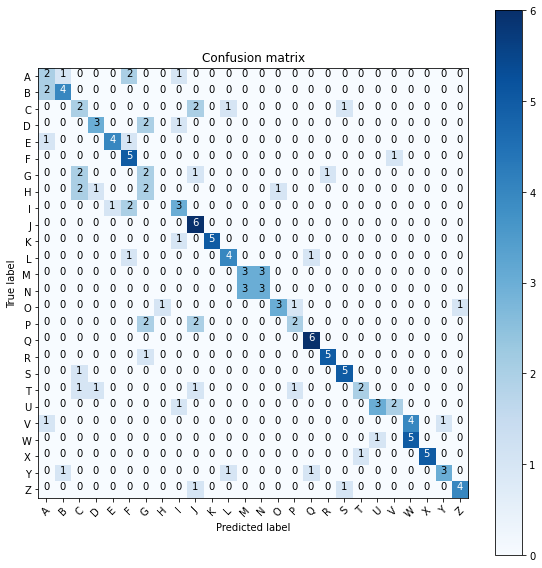

Epoch 1/300
18/18 [==============================] - 7s 160ms/step - loss: 3.2945 - accuracy: 0.0454 - val_loss: 3.1369 - val_accuracy: 0.1154
Epoch 2/300
18/18 [==============================] - 1s 66ms/step - loss: 3.1799 - accuracy: 0.0967 - val_loss: 3.0618 - val_accuracy: 0.1667
Epoch 3/300
18/18 [==============================] - 1s 64ms/step - loss: 3.0965 - accuracy: 0.1063 - val_loss: 2.9433 - val_accuracy: 0.1538
Epoch 4/300
18/18 [==============================] - 1s 65ms/step - loss: 2.9891 - accuracy: 0.1056 - val_loss: 2.8316 - val_accuracy: 0.1154
Epoch 5/300
18/18 [==============================] - 1s 65ms/step - loss: 2.8628 - accuracy: 0.1514 - val_loss: 2.7049 - val_accuracy: 0.1923
Epoch 6/300
18/18 [==============================] - 1s 65ms/step - loss: 2.8097 - accuracy: 0.1608 - val_loss: 2.6168 - val_accuracy: 0.1410
Epoch 7/300
18/18 [==============================] - 1s 65ms/step - loss: 2.7552 - accuracy: 0.1248 - val_loss: 2.4853 - val_accuracy: 0.2179
Epoch

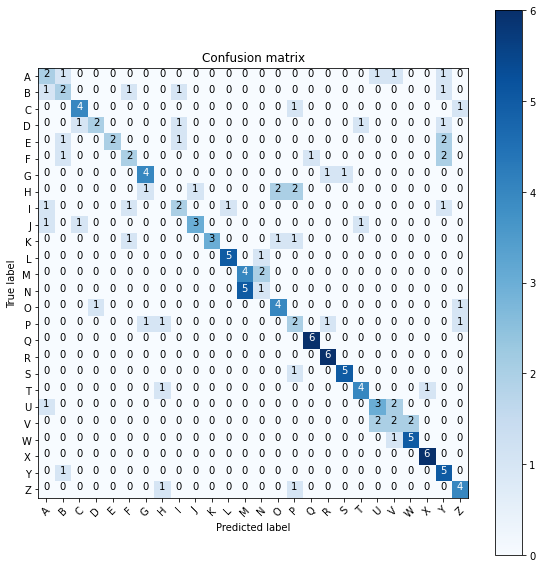

Epoch 1/300
18/18 [==============================] - 7s 159ms/step - loss: 3.3040 - accuracy: 0.0322 - val_loss: 3.1791 - val_accuracy: 0.0897
Epoch 2/300
18/18 [==============================] - 1s 64ms/step - loss: 3.1974 - accuracy: 0.0754 - val_loss: 3.1101 - val_accuracy: 0.1538
Epoch 3/300
18/18 [==============================] - 1s 64ms/step - loss: 3.1206 - accuracy: 0.1038 - val_loss: 3.0296 - val_accuracy: 0.1282
Epoch 4/300
18/18 [==============================] - 1s 65ms/step - loss: 3.0720 - accuracy: 0.1285 - val_loss: 2.9537 - val_accuracy: 0.1795
Epoch 5/300
18/18 [==============================] - 1s 65ms/step - loss: 2.9869 - accuracy: 0.1312 - val_loss: 2.8448 - val_accuracy: 0.1795
Epoch 6/300
18/18 [==============================] - 1s 64ms/step - loss: 2.8432 - accuracy: 0.1541 - val_loss: 2.7124 - val_accuracy: 0.2564
Epoch 7/300
18/18 [==============================] - 1s 66ms/step - loss: 2.7688 - accuracy: 0.1713 - val_loss: 2.6036 - val_accuracy: 0.2692
Epoch

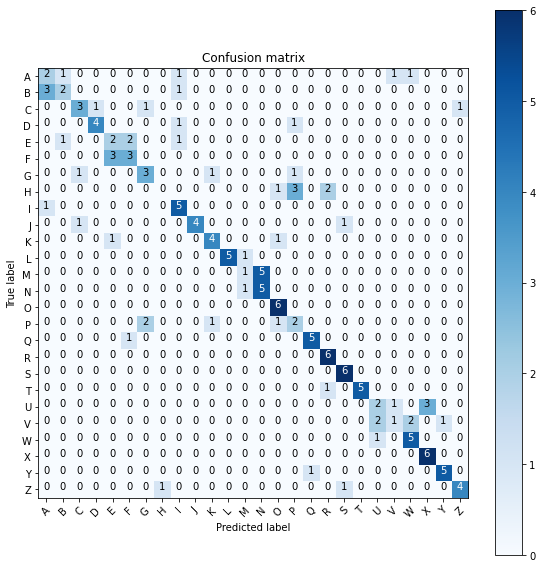

Epoch 1/300
18/18 [==============================] - 7s 135ms/step - loss: 3.2983 - accuracy: 0.0372 - val_loss: 3.1528 - val_accuracy: 0.2051
Epoch 2/300
18/18 [==============================] - 1s 67ms/step - loss: 3.1884 - accuracy: 0.0833 - val_loss: 3.0853 - val_accuracy: 0.1923
Epoch 3/300
18/18 [==============================] - 1s 66ms/step - loss: 3.1216 - accuracy: 0.0981 - val_loss: 2.9737 - val_accuracy: 0.2436
Epoch 4/300
18/18 [==============================] - 1s 66ms/step - loss: 3.0057 - accuracy: 0.1505 - val_loss: 2.8626 - val_accuracy: 0.2308
Epoch 5/300
18/18 [==============================] - 1s 68ms/step - loss: 2.9310 - accuracy: 0.1600 - val_loss: 2.6933 - val_accuracy: 0.2436
Epoch 6/300
18/18 [==============================] - 1s 66ms/step - loss: 2.8065 - accuracy: 0.1909 - val_loss: 2.5386 - val_accuracy: 0.3205
Epoch 7/300
18/18 [==============================] - 1s 66ms/step - loss: 2.7253 - accuracy: 0.2236 - val_loss: 2.4301 - val_accuracy: 0.2692
Epoch

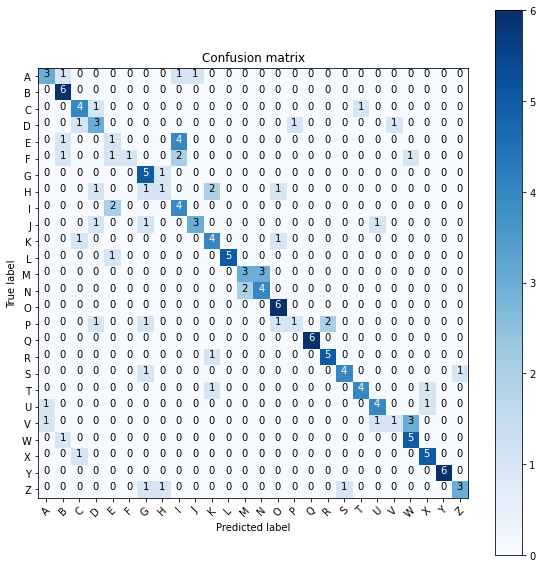

Epoch 1/300
18/18 [==============================] - 7s 137ms/step - loss: 3.2897 - accuracy: 0.0329 - val_loss: 3.1987 - val_accuracy: 0.1923
Epoch 2/300
18/18 [==============================] - 1s 66ms/step - loss: 3.1956 - accuracy: 0.0786 - val_loss: 3.0936 - val_accuracy: 0.1667
Epoch 3/300
18/18 [==============================] - 1s 66ms/step - loss: 3.0623 - accuracy: 0.0958 - val_loss: 2.9996 - val_accuracy: 0.1410
Epoch 4/300
18/18 [==============================] - 1s 66ms/step - loss: 2.9637 - accuracy: 0.1431 - val_loss: 2.8651 - val_accuracy: 0.2179
Epoch 5/300
18/18 [==============================] - 1s 66ms/step - loss: 2.7733 - accuracy: 0.1676 - val_loss: 2.7556 - val_accuracy: 0.2308
Epoch 6/300
18/18 [==============================] - 1s 67ms/step - loss: 2.6271 - accuracy: 0.2029 - val_loss: 2.6015 - val_accuracy: 0.2179
Epoch 7/300
18/18 [==============================] - 1s 66ms/step - loss: 2.6064 - accuracy: 0.2180 - val_loss: 2.4506 - val_accuracy: 0.2821
Epoch

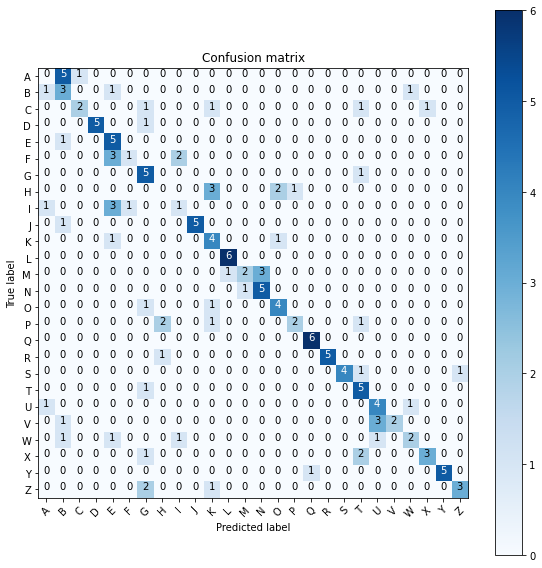

Epoch 1/300
18/18 [==============================] - 7s 136ms/step - loss: 3.2919 - accuracy: 0.0378 - val_loss: 3.1887 - val_accuracy: 0.0385
Epoch 2/300
18/18 [==============================] - 1s 67ms/step - loss: 3.2009 - accuracy: 0.0451 - val_loss: 3.1334 - val_accuracy: 0.1410
Epoch 3/300
18/18 [==============================] - 1s 67ms/step - loss: 3.1104 - accuracy: 0.0789 - val_loss: 3.0401 - val_accuracy: 0.1667
Epoch 4/300
18/18 [==============================] - 1s 67ms/step - loss: 3.0017 - accuracy: 0.1294 - val_loss: 2.9189 - val_accuracy: 0.2179
Epoch 5/300
18/18 [==============================] - 1s 67ms/step - loss: 2.8587 - accuracy: 0.1685 - val_loss: 2.8005 - val_accuracy: 0.2308
Epoch 6/300
18/18 [==============================] - 1s 68ms/step - loss: 2.7423 - accuracy: 0.2002 - val_loss: 2.6736 - val_accuracy: 0.2436
Epoch 7/300
18/18 [==============================] - 1s 67ms/step - loss: 2.6221 - accuracy: 0.1826 - val_loss: 2.5482 - val_accuracy: 0.3205
Epoch

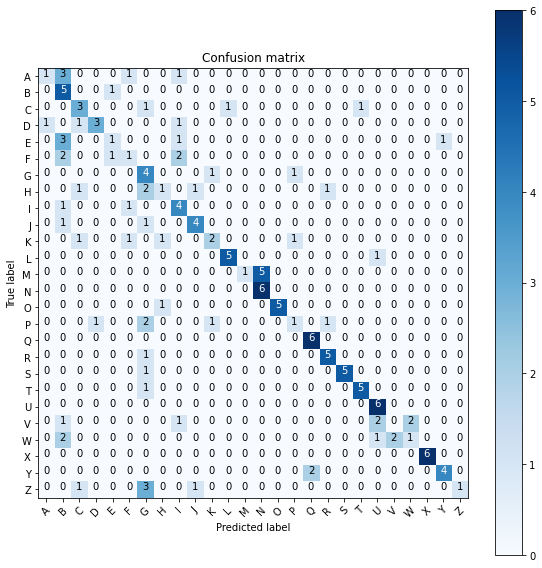

Epoch 1/300
18/18 [==============================] - 7s 160ms/step - loss: 3.2617 - accuracy: 0.0439 - val_loss: 3.2145 - val_accuracy: 0.0769
Epoch 2/300
18/18 [==============================] - 1s 69ms/step - loss: 3.2058 - accuracy: 0.0699 - val_loss: 3.1681 - val_accuracy: 0.0897
Epoch 3/300
18/18 [==============================] - 1s 67ms/step - loss: 3.1862 - accuracy: 0.0615 - val_loss: 3.1081 - val_accuracy: 0.1282
Epoch 4/300
18/18 [==============================] - 1s 66ms/step - loss: 3.0806 - accuracy: 0.1148 - val_loss: 3.0220 - val_accuracy: 0.1282
Epoch 5/300
18/18 [==============================] - 1s 67ms/step - loss: 2.9580 - accuracy: 0.1489 - val_loss: 2.9248 - val_accuracy: 0.2436
Epoch 6/300
18/18 [==============================] - 1s 67ms/step - loss: 2.9003 - accuracy: 0.1473 - val_loss: 2.8376 - val_accuracy: 0.1410
Epoch 7/300
18/18 [==============================] - 1s 67ms/step - loss: 2.7451 - accuracy: 0.1961 - val_loss: 2.7516 - val_accuracy: 0.1667
Epoch

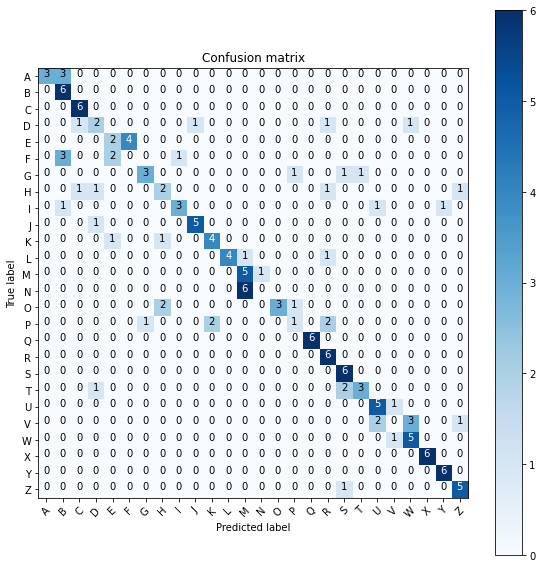

Epoch 1/300
18/18 [==============================] - 7s 139ms/step - loss: 3.3006 - accuracy: 0.0658 - val_loss: 3.1752 - val_accuracy: 0.1026
Epoch 2/300
18/18 [==============================] - 1s 67ms/step - loss: 3.1803 - accuracy: 0.0804 - val_loss: 3.1027 - val_accuracy: 0.2436
Epoch 3/300
18/18 [==============================] - 1s 67ms/step - loss: 3.0893 - accuracy: 0.1263 - val_loss: 2.9557 - val_accuracy: 0.2564
Epoch 4/300
18/18 [==============================] - 1s 66ms/step - loss: 2.9759 - accuracy: 0.1575 - val_loss: 2.8260 - val_accuracy: 0.2436
Epoch 5/300
18/18 [==============================] - 1s 67ms/step - loss: 2.8784 - accuracy: 0.1616 - val_loss: 2.6544 - val_accuracy: 0.3077
Epoch 6/300
18/18 [==============================] - 1s 68ms/step - loss: 2.6964 - accuracy: 0.2006 - val_loss: 2.5136 - val_accuracy: 0.3462
Epoch 7/300
18/18 [==============================] - 1s 67ms/step - loss: 2.6490 - accuracy: 0.2130 - val_loss: 2.3972 - val_accuracy: 0.3974
Epoch

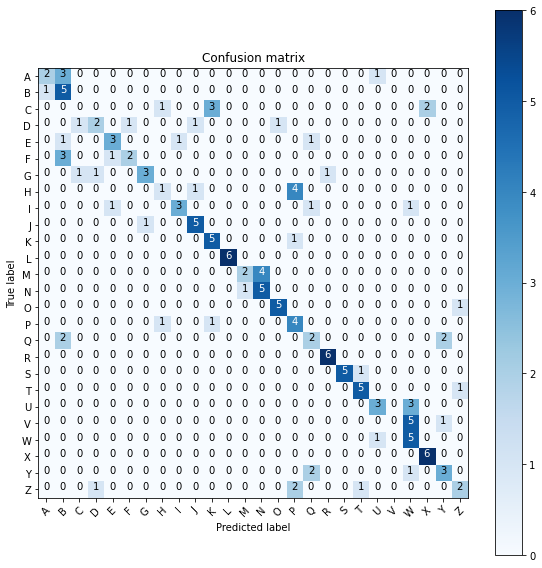

Epoch 1/300
18/18 [==============================] - 7s 136ms/step - loss: 3.3221 - accuracy: 0.0397 - val_loss: 3.1975 - val_accuracy: 0.0641
Epoch 2/300
18/18 [==============================] - 1s 67ms/step - loss: 3.1583 - accuracy: 0.0777 - val_loss: 3.1582 - val_accuracy: 0.1154
Epoch 3/300
18/18 [==============================] - 1s 68ms/step - loss: 3.1385 - accuracy: 0.0883 - val_loss: 3.0729 - val_accuracy: 0.1923
Epoch 4/300
18/18 [==============================] - 1s 69ms/step - loss: 3.0333 - accuracy: 0.1153 - val_loss: 2.9769 - val_accuracy: 0.2692
Epoch 5/300
18/18 [==============================] - 1s 67ms/step - loss: 2.9472 - accuracy: 0.1403 - val_loss: 2.8118 - val_accuracy: 0.2436
Epoch 6/300
18/18 [==============================] - 1s 66ms/step - loss: 2.8170 - accuracy: 0.1621 - val_loss: 2.6839 - val_accuracy: 0.2436
Epoch 7/300
18/18 [==============================] - 1s 67ms/step - loss: 2.6943 - accuracy: 0.1853 - val_loss: 2.5917 - val_accuracy: 0.2308
Epoch

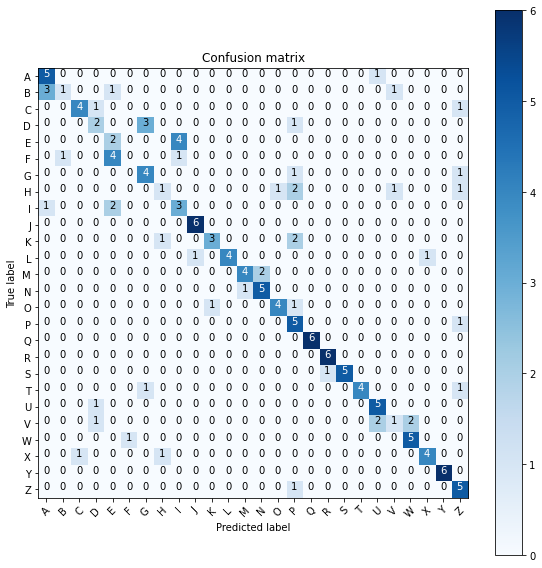

Epoch 1/300
18/18 [==============================] - 7s 137ms/step - loss: 3.2903 - accuracy: 0.0246 - val_loss: 3.1942 - val_accuracy: 0.0641
Epoch 2/300
18/18 [==============================] - 1s 67ms/step - loss: 3.1851 - accuracy: 0.0755 - val_loss: 3.1135 - val_accuracy: 0.1282
Epoch 3/300
18/18 [==============================] - 1s 67ms/step - loss: 3.0955 - accuracy: 0.0964 - val_loss: 2.9648 - val_accuracy: 0.1538
Epoch 4/300
18/18 [==============================] - 1s 69ms/step - loss: 2.9996 - accuracy: 0.1252 - val_loss: 2.8608 - val_accuracy: 0.2436
Epoch 5/300
18/18 [==============================] - 1s 66ms/step - loss: 2.8457 - accuracy: 0.1607 - val_loss: 2.7591 - val_accuracy: 0.3077
Epoch 6/300
18/18 [==============================] - 1s 68ms/step - loss: 2.7496 - accuracy: 0.1676 - val_loss: 2.5706 - val_accuracy: 0.3077
Epoch 7/300
18/18 [==============================] - 1s 68ms/step - loss: 2.6638 - accuracy: 0.2131 - val_loss: 2.4994 - val_accuracy: 0.3462
Epoch

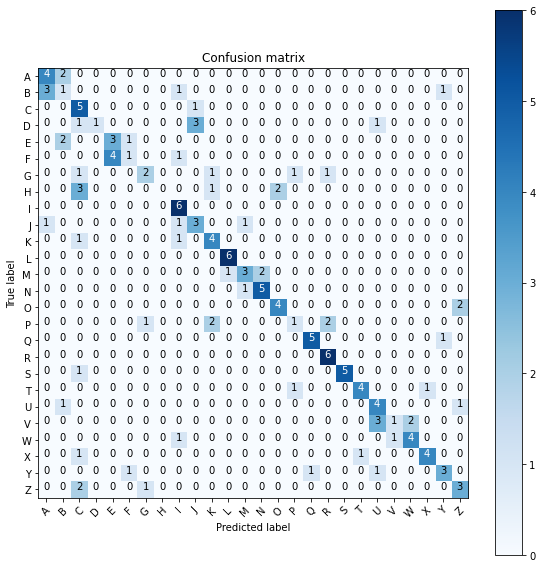

Epoch 1/300
18/18 [==============================] - 7s 164ms/step - loss: 3.2880 - accuracy: 0.0504 - val_loss: 3.2061 - val_accuracy: 0.0769
Epoch 2/300
18/18 [==============================] - 1s 69ms/step - loss: 3.1760 - accuracy: 0.0817 - val_loss: 3.1626 - val_accuracy: 0.0641
Epoch 3/300
18/18 [==============================] - 1s 68ms/step - loss: 3.1100 - accuracy: 0.1122 - val_loss: 3.1023 - val_accuracy: 0.0641
Epoch 4/300
18/18 [==============================] - 1s 69ms/step - loss: 3.0189 - accuracy: 0.1537 - val_loss: 3.0083 - val_accuracy: 0.0641
Epoch 5/300
18/18 [==============================] - 1s 67ms/step - loss: 2.9671 - accuracy: 0.1082 - val_loss: 2.9354 - val_accuracy: 0.0897
Epoch 6/300
18/18 [==============================] - 1s 69ms/step - loss: 2.9283 - accuracy: 0.1356 - val_loss: 2.8400 - val_accuracy: 0.0769
Epoch 7/300
18/18 [==============================] - 1s 68ms/step - loss: 2.8283 - accuracy: 0.1489 - val_loss: 2.7710 - val_accuracy: 0.1795
Epoch

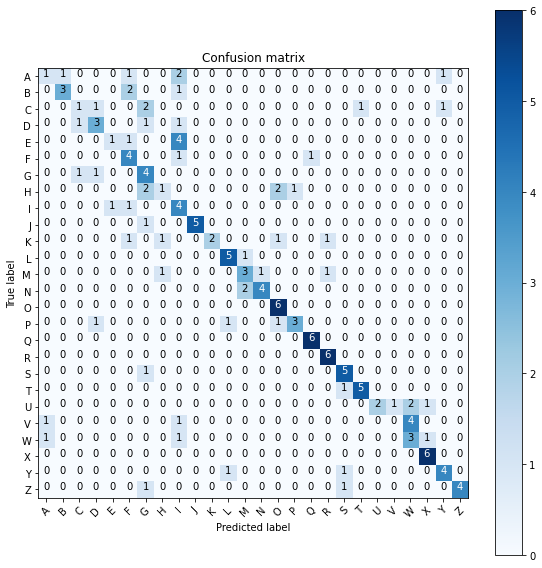

Epoch 1/300
18/18 [==============================] - 7s 138ms/step - loss: 3.2758 - accuracy: 0.0556 - val_loss: 3.2175 - val_accuracy: 0.0513
Epoch 2/300
18/18 [==============================] - 1s 68ms/step - loss: 3.1876 - accuracy: 0.1025 - val_loss: 3.1826 - val_accuracy: 0.1026
Epoch 3/300
18/18 [==============================] - 1s 69ms/step - loss: 3.0816 - accuracy: 0.1537 - val_loss: 3.1215 - val_accuracy: 0.1282
Epoch 4/300
18/18 [==============================] - 1s 69ms/step - loss: 3.0545 - accuracy: 0.1446 - val_loss: 3.0194 - val_accuracy: 0.1410
Epoch 5/300
18/18 [==============================] - 1s 68ms/step - loss: 2.9597 - accuracy: 0.1242 - val_loss: 2.9326 - val_accuracy: 0.1923
Epoch 6/300
18/18 [==============================] - 1s 69ms/step - loss: 2.8087 - accuracy: 0.1929 - val_loss: 2.7804 - val_accuracy: 0.1667
Epoch 7/300
18/18 [==============================] - 1s 67ms/step - loss: 2.6806 - accuracy: 0.2037 - val_loss: 2.6805 - val_accuracy: 0.2308
Epoch

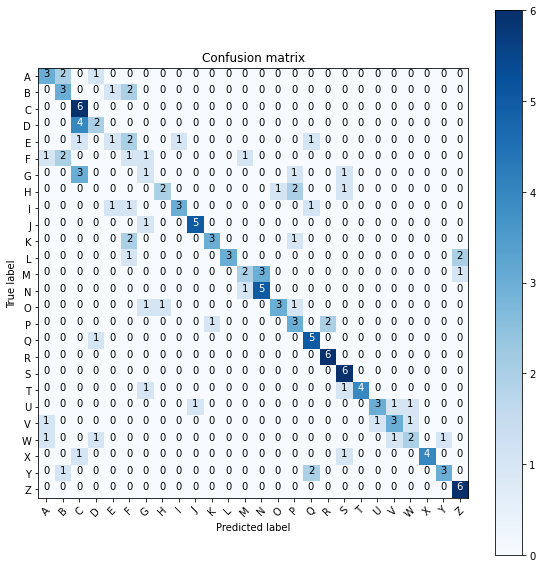

Epoch 1/300
18/18 [==============================] - 7s 136ms/step - loss: 3.3053 - accuracy: 0.0431 - val_loss: 3.2091 - val_accuracy: 0.0897
Epoch 2/300
18/18 [==============================] - 1s 76ms/step - loss: 3.1932 - accuracy: 0.0677 - val_loss: 3.1294 - val_accuracy: 0.1154
Epoch 3/300
18/18 [==============================] - 1s 69ms/step - loss: 3.1095 - accuracy: 0.0868 - val_loss: 3.0442 - val_accuracy: 0.1154
Epoch 4/300
18/18 [==============================] - 1s 69ms/step - loss: 3.0130 - accuracy: 0.1068 - val_loss: 2.9859 - val_accuracy: 0.1154
Epoch 5/300
18/18 [==============================] - 1s 68ms/step - loss: 2.8791 - accuracy: 0.1766 - val_loss: 2.8636 - val_accuracy: 0.1282
Epoch 6/300
18/18 [==============================] - 1s 70ms/step - loss: 2.7544 - accuracy: 0.1716 - val_loss: 2.7327 - val_accuracy: 0.1795
Epoch 7/300
18/18 [==============================] - 1s 69ms/step - loss: 2.6754 - accuracy: 0.2021 - val_loss: 2.7187 - val_accuracy: 0.2179
Epoch

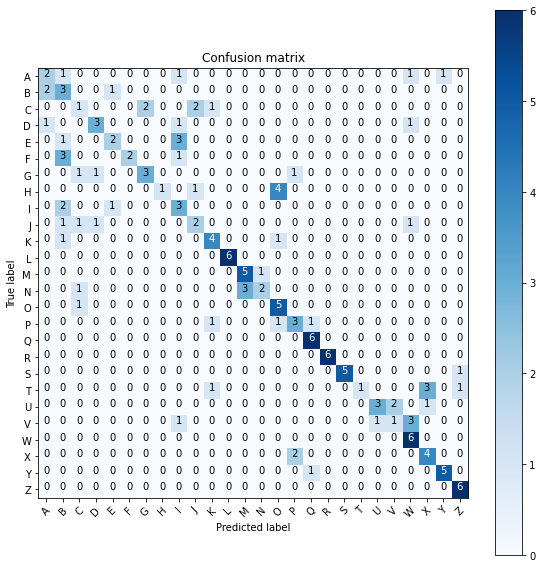

Epoch 1/300
18/18 [==============================] - 7s 142ms/step - loss: 3.2779 - accuracy: 0.0592 - val_loss: 3.1575 - val_accuracy: 0.0897
Epoch 2/300
18/18 [==============================] - 1s 69ms/step - loss: 3.1840 - accuracy: 0.0663 - val_loss: 3.1023 - val_accuracy: 0.1282
Epoch 3/300
18/18 [==============================] - 1s 68ms/step - loss: 3.0946 - accuracy: 0.0970 - val_loss: 2.9730 - val_accuracy: 0.1795
Epoch 4/300
18/18 [==============================] - 1s 67ms/step - loss: 3.0212 - accuracy: 0.0990 - val_loss: 2.8584 - val_accuracy: 0.2308
Epoch 5/300
18/18 [==============================] - 1s 68ms/step - loss: 2.8729 - accuracy: 0.1611 - val_loss: 2.7563 - val_accuracy: 0.2308
Epoch 6/300
18/18 [==============================] - 1s 67ms/step - loss: 2.8349 - accuracy: 0.1347 - val_loss: 2.6194 - val_accuracy: 0.2821
Epoch 7/300
18/18 [==============================] - 1s 69ms/step - loss: 2.7295 - accuracy: 0.2003 - val_loss: 2.5089 - val_accuracy: 0.3205
Epoch

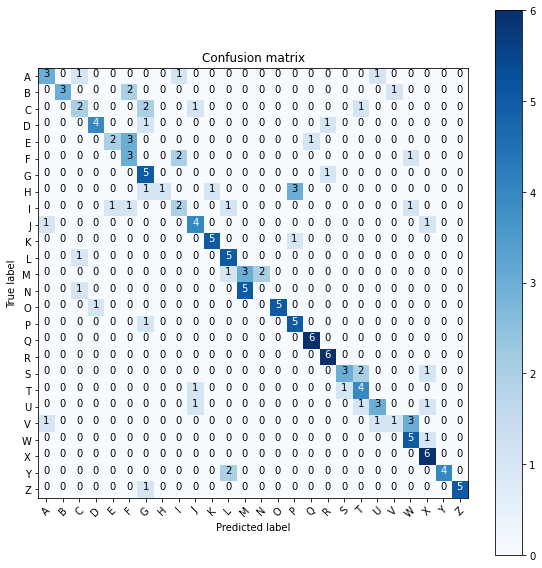

Epoch 1/300
18/18 [==============================] - 7s 140ms/step - loss: 3.3107 - accuracy: 0.0369 - val_loss: 3.1718 - val_accuracy: 0.0897
Epoch 2/300
18/18 [==============================] - 1s 70ms/step - loss: 3.1997 - accuracy: 0.0837 - val_loss: 3.1027 - val_accuracy: 0.1667
Epoch 3/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1200 - accuracy: 0.0800 - val_loss: 3.0133 - val_accuracy: 0.2179
Epoch 4/300
18/18 [==============================] - 1s 76ms/step - loss: 3.0635 - accuracy: 0.0794 - val_loss: 2.9152 - val_accuracy: 0.2051
Epoch 5/300
18/18 [==============================] - 1s 70ms/step - loss: 2.9662 - accuracy: 0.1470 - val_loss: 2.8225 - val_accuracy: 0.2179
Epoch 6/300
18/18 [==============================] - 1s 70ms/step - loss: 2.8551 - accuracy: 0.1536 - val_loss: 2.7077 - val_accuracy: 0.2821
Epoch 7/300
18/18 [==============================] - 1s 69ms/step - loss: 2.7113 - accuracy: 0.2220 - val_loss: 2.5893 - val_accuracy: 0.2949
Epoch

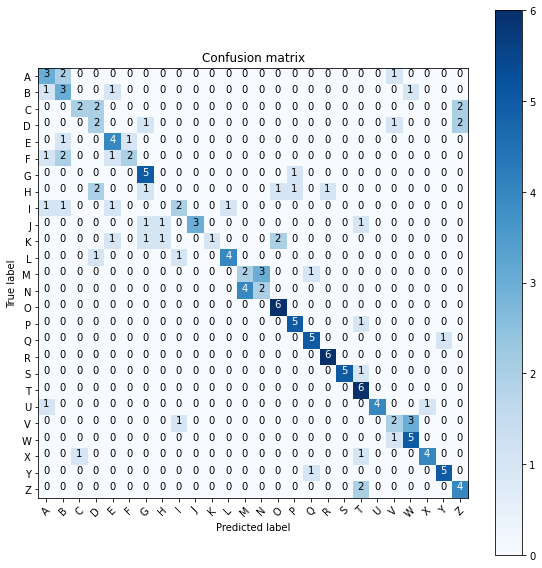

Epoch 1/300
18/18 [==============================] - 7s 135ms/step - loss: 3.2926 - accuracy: 0.0439 - val_loss: 3.1482 - val_accuracy: 0.1795
Epoch 2/300
18/18 [==============================] - 1s 70ms/step - loss: 3.1933 - accuracy: 0.0571 - val_loss: 3.0933 - val_accuracy: 0.2179
Epoch 3/300
18/18 [==============================] - 1s 69ms/step - loss: 3.1344 - accuracy: 0.0899 - val_loss: 3.0387 - val_accuracy: 0.2179
Epoch 4/300
18/18 [==============================] - 1s 69ms/step - loss: 3.0181 - accuracy: 0.1285 - val_loss: 2.9313 - val_accuracy: 0.2179
Epoch 5/300
18/18 [==============================] - 1s 69ms/step - loss: 2.9457 - accuracy: 0.1442 - val_loss: 2.8083 - val_accuracy: 0.2564
Epoch 6/300
18/18 [==============================] - 1s 69ms/step - loss: 2.7843 - accuracy: 0.1818 - val_loss: 2.7221 - val_accuracy: 0.1795
Epoch 7/300
18/18 [==============================] - 1s 69ms/step - loss: 2.7144 - accuracy: 0.1829 - val_loss: 2.6050 - val_accuracy: 0.2692
Epoch

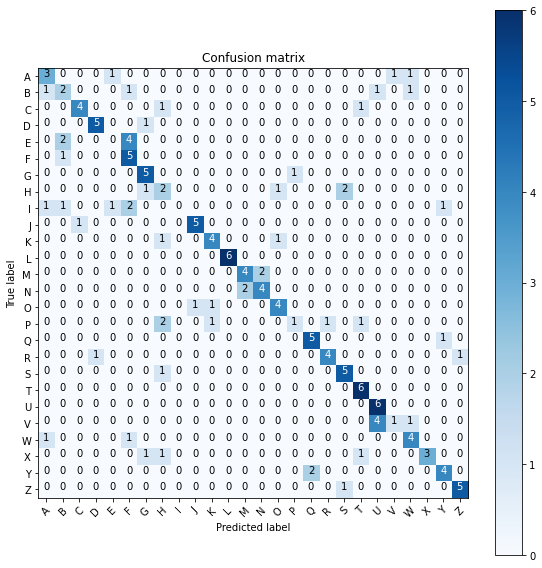

Epoch 1/300
18/18 [==============================] - 7s 137ms/step - loss: 3.2766 - accuracy: 0.0408 - val_loss: 3.2248 - val_accuracy: 0.0128
Epoch 2/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1849 - accuracy: 0.0685 - val_loss: 3.1641 - val_accuracy: 0.0513
Epoch 3/300
18/18 [==============================] - 1s 70ms/step - loss: 3.1066 - accuracy: 0.0939 - val_loss: 3.1132 - val_accuracy: 0.0897
Epoch 4/300
18/18 [==============================] - 1s 69ms/step - loss: 3.0394 - accuracy: 0.1254 - val_loss: 3.0193 - val_accuracy: 0.1154
Epoch 5/300
18/18 [==============================] - 1s 69ms/step - loss: 2.9101 - accuracy: 0.1590 - val_loss: 2.8783 - val_accuracy: 0.2179
Epoch 6/300
18/18 [==============================] - 1s 68ms/step - loss: 2.7919 - accuracy: 0.1960 - val_loss: 2.7521 - val_accuracy: 0.2051
Epoch 7/300
18/18 [==============================] - 1s 69ms/step - loss: 2.7227 - accuracy: 0.1699 - val_loss: 2.5938 - val_accuracy: 0.2564
Epoch

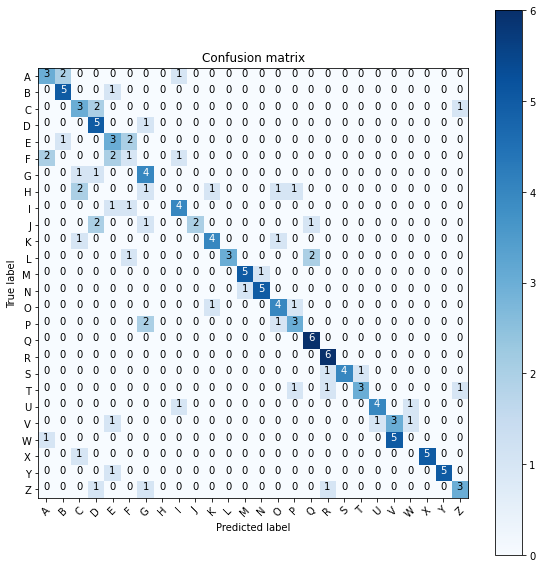

Epoch 1/300
18/18 [==============================] - 7s 138ms/step - loss: 3.2870 - accuracy: 0.0297 - val_loss: 3.1912 - val_accuracy: 0.1026
Epoch 2/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1986 - accuracy: 0.1064 - val_loss: 3.1282 - val_accuracy: 0.0769
Epoch 3/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1576 - accuracy: 0.0647 - val_loss: 3.0619 - val_accuracy: 0.1667
Epoch 4/300
18/18 [==============================] - 1s 70ms/step - loss: 3.0255 - accuracy: 0.1360 - val_loss: 2.9260 - val_accuracy: 0.2436
Epoch 5/300
18/18 [==============================] - 1s 69ms/step - loss: 2.9050 - accuracy: 0.1849 - val_loss: 2.8187 - val_accuracy: 0.2308
Epoch 6/300
18/18 [==============================] - 1s 70ms/step - loss: 2.8239 - accuracy: 0.1739 - val_loss: 2.6483 - val_accuracy: 0.2821
Epoch 7/300
18/18 [==============================] - 1s 79ms/step - loss: 2.7311 - accuracy: 0.1773 - val_loss: 2.5432 - val_accuracy: 0.2821
Epoch

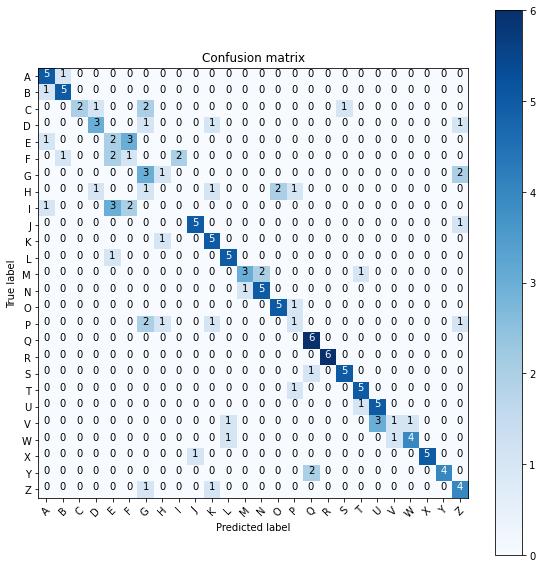

Epoch 1/300
18/18 [==============================] - 7s 138ms/step - loss: 3.3136 - accuracy: 0.0322 - val_loss: 3.1868 - val_accuracy: 0.0769
Epoch 2/300
18/18 [==============================] - 1s 69ms/step - loss: 3.1922 - accuracy: 0.0764 - val_loss: 3.1038 - val_accuracy: 0.1026
Epoch 3/300
18/18 [==============================] - 1s 70ms/step - loss: 3.1112 - accuracy: 0.1119 - val_loss: 3.0294 - val_accuracy: 0.2051
Epoch 4/300
18/18 [==============================] - 1s 71ms/step - loss: 3.0762 - accuracy: 0.1243 - val_loss: 2.9565 - val_accuracy: 0.1667
Epoch 5/300
18/18 [==============================] - 1s 70ms/step - loss: 2.9897 - accuracy: 0.1478 - val_loss: 2.7997 - val_accuracy: 0.2821
Epoch 6/300
18/18 [==============================] - 1s 71ms/step - loss: 2.8131 - accuracy: 0.1844 - val_loss: 2.6874 - val_accuracy: 0.2692
Epoch 7/300
18/18 [==============================] - 1s 78ms/step - loss: 2.6810 - accuracy: 0.1803 - val_loss: 2.5153 - val_accuracy: 0.3333
Epoch

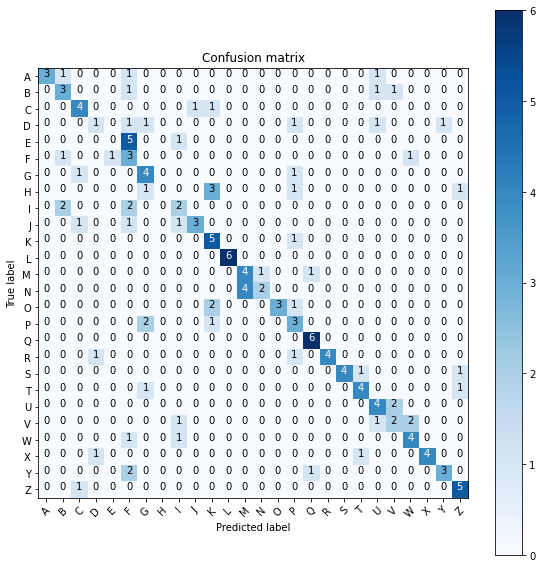

Epoch 1/300
18/18 [==============================] - 7s 164ms/step - loss: 3.2675 - accuracy: 0.0452 - val_loss: 3.1689 - val_accuracy: 0.0897
Epoch 2/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1964 - accuracy: 0.0525 - val_loss: 3.0341 - val_accuracy: 0.1667
Epoch 3/300
18/18 [==============================] - 1s 71ms/step - loss: 3.0692 - accuracy: 0.0923 - val_loss: 2.9181 - val_accuracy: 0.2051
Epoch 4/300
18/18 [==============================] - 1s 71ms/step - loss: 2.9348 - accuracy: 0.1386 - val_loss: 2.7958 - val_accuracy: 0.2051
Epoch 5/300
18/18 [==============================] - 1s 70ms/step - loss: 2.8444 - accuracy: 0.1784 - val_loss: 2.6370 - val_accuracy: 0.2692
Epoch 6/300
18/18 [==============================] - 1s 71ms/step - loss: 2.7352 - accuracy: 0.1899 - val_loss: 2.4578 - val_accuracy: 0.3846
Epoch 7/300
18/18 [==============================] - 1s 69ms/step - loss: 2.6154 - accuracy: 0.2047 - val_loss: 2.3499 - val_accuracy: 0.4231
Epoch

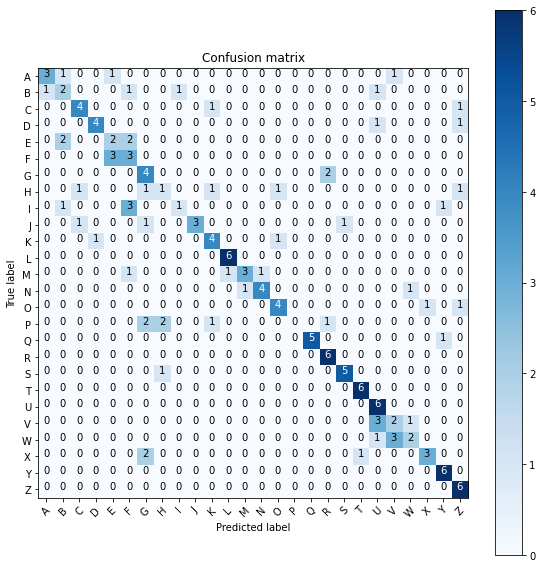

Epoch 1/300
18/18 [==============================] - 7s 137ms/step - loss: 3.2725 - accuracy: 0.0449 - val_loss: 3.1770 - val_accuracy: 0.0641
Epoch 2/300
18/18 [==============================] - 1s 70ms/step - loss: 3.1816 - accuracy: 0.0758 - val_loss: 3.0875 - val_accuracy: 0.0769
Epoch 3/300
18/18 [==============================] - 1s 70ms/step - loss: 3.0802 - accuracy: 0.0897 - val_loss: 2.9499 - val_accuracy: 0.1026
Epoch 4/300
18/18 [==============================] - 1s 70ms/step - loss: 2.9802 - accuracy: 0.1212 - val_loss: 2.8683 - val_accuracy: 0.1410
Epoch 5/300
18/18 [==============================] - 1s 71ms/step - loss: 2.8222 - accuracy: 0.1717 - val_loss: 2.8012 - val_accuracy: 0.1795
Epoch 6/300
18/18 [==============================] - 1s 71ms/step - loss: 2.7338 - accuracy: 0.1867 - val_loss: 2.6477 - val_accuracy: 0.1538
Epoch 7/300
18/18 [==============================] - 1s 71ms/step - loss: 2.6372 - accuracy: 0.2280 - val_loss: 2.5057 - val_accuracy: 0.2051
Epoch

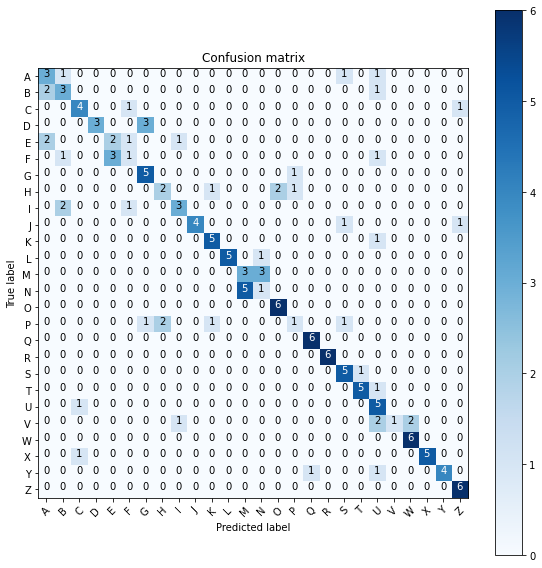

Epoch 1/300
18/18 [==============================] - 7s 138ms/step - loss: 3.2746 - accuracy: 0.0385 - val_loss: 3.1505 - val_accuracy: 0.1154
Epoch 2/300
18/18 [==============================] - 1s 72ms/step - loss: 3.1682 - accuracy: 0.0780 - val_loss: 3.0169 - val_accuracy: 0.1410
Epoch 3/300
18/18 [==============================] - 1s 70ms/step - loss: 3.0581 - accuracy: 0.0986 - val_loss: 2.9001 - val_accuracy: 0.1538
Epoch 4/300
18/18 [==============================] - 1s 71ms/step - loss: 2.9517 - accuracy: 0.1119 - val_loss: 2.7879 - val_accuracy: 0.1410
Epoch 5/300
18/18 [==============================] - 1s 70ms/step - loss: 2.8709 - accuracy: 0.1185 - val_loss: 2.6551 - val_accuracy: 0.2564
Epoch 6/300
18/18 [==============================] - 1s 71ms/step - loss: 2.7828 - accuracy: 0.1203 - val_loss: 2.5611 - val_accuracy: 0.2179
Epoch 7/300
18/18 [==============================] - 1s 71ms/step - loss: 2.6613 - accuracy: 0.1777 - val_loss: 2.4727 - val_accuracy: 0.2179
Epoch

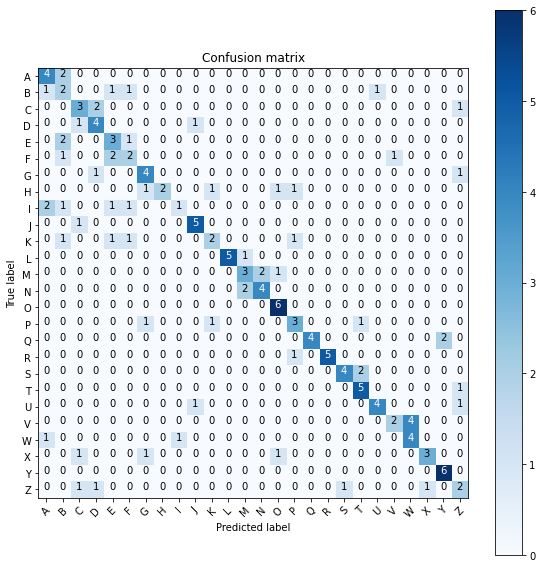

Epoch 1/300
18/18 [==============================] - 7s 142ms/step - loss: 3.2388 - accuracy: 0.0561 - val_loss: 3.1626 - val_accuracy: 0.0641
Epoch 2/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1667 - accuracy: 0.0820 - val_loss: 3.1092 - val_accuracy: 0.0641
Epoch 3/300
18/18 [==============================] - 1s 71ms/step - loss: 3.0683 - accuracy: 0.1177 - val_loss: 2.9868 - val_accuracy: 0.1154
Epoch 4/300
18/18 [==============================] - 1s 71ms/step - loss: 2.9332 - accuracy: 0.1448 - val_loss: 2.9008 - val_accuracy: 0.1538
Epoch 5/300
18/18 [==============================] - 1s 72ms/step - loss: 2.8497 - accuracy: 0.1777 - val_loss: 2.7739 - val_accuracy: 0.1667
Epoch 6/300
18/18 [==============================] - 1s 73ms/step - loss: 2.7859 - accuracy: 0.2025 - val_loss: 2.6932 - val_accuracy: 0.2436
Epoch 7/300
18/18 [==============================] - 1s 72ms/step - loss: 2.6819 - accuracy: 0.1963 - val_loss: 2.5514 - val_accuracy: 0.2308
Epoch

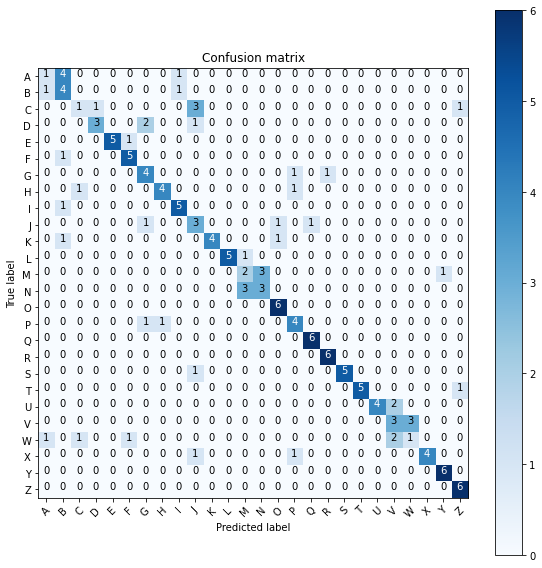

Epoch 1/300
18/18 [==============================] - 7s 139ms/step - loss: 3.3074 - accuracy: 0.0375 - val_loss: 3.2016 - val_accuracy: 0.0513
Epoch 2/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1912 - accuracy: 0.0839 - val_loss: 3.1218 - val_accuracy: 0.1410
Epoch 3/300
18/18 [==============================] - 1s 71ms/step - loss: 3.1084 - accuracy: 0.1176 - val_loss: 3.0259 - val_accuracy: 0.1154
Epoch 4/300
18/18 [==============================] - 1s 71ms/step - loss: 2.9944 - accuracy: 0.1550 - val_loss: 2.9276 - val_accuracy: 0.1538
Epoch 5/300
18/18 [==============================] - 1s 71ms/step - loss: 2.8745 - accuracy: 0.1500 - val_loss: 2.8187 - val_accuracy: 0.2051
Epoch 6/300
18/18 [==============================] - 1s 73ms/step - loss: 2.7917 - accuracy: 0.1578 - val_loss: 2.8570 - val_accuracy: 0.1282
Epoch 7/300
18/18 [==============================] - 1s 70ms/step - loss: 2.6967 - accuracy: 0.2088 - val_loss: 2.5642 - val_accuracy: 0.2949
Epoch

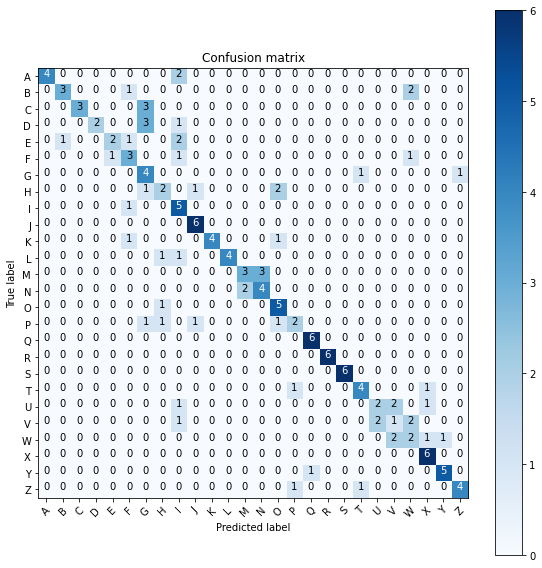

Losses
[[1.15378249]
 [1.30684268]
 [1.60533988]
 [1.44325292]
 [1.45507693]
 [1.3803246 ]
 [1.34030831]
 [1.36590171]
 [1.2246778 ]
 [1.200158  ]
 [1.30598688]
 [1.4693222 ]
 [1.12862825]
 [1.22195828]
 [1.26041746]
 [1.42382967]
 [1.34899783]
 [1.42824042]
 [1.48170793]
 [1.2832427 ]
 [1.32252312]
 [1.20572114]
 [1.30744684]
 [1.14259636]
 [1.55151498]
 [1.29328406]
 [1.07312965]
 [1.26674497]
 [1.1100266 ]
 [1.09495032]]
Accuracies
[[0.64102566]
 [0.58333331]
 [0.47435898]
 [0.53846157]
 [0.47435898]
 [0.55769229]
 [0.57051283]
 [0.56410259]
 [0.61538464]
 [0.62179488]
 [0.57051283]
 [0.55128205]
 [0.62179488]
 [0.57692307]
 [0.64102566]
 [0.56410259]
 [0.58333331]
 [0.56410259]
 [0.57692307]
 [0.60897434]
 [0.58974361]
 [0.62179488]
 [0.59615386]
 [0.60897434]
 [0.55128205]
 [0.60897434]
 [0.64102566]
 [0.58974361]
 [0.67307693]
 [0.62820512]]
Avg loss: 1.3065311670303346 +/- 0.13508819708013678
Avg accuracy: 0.5869658172130585 +/- 0.043717865921115207


In [ ]:
# Experiment 3: training and test on the original dataset, 30 random splits
model = BidirectionalLSTMGestureClassifier()
model.runExperiment(dataset_path=ORIGINAL_DATA_DIR, split_number=30, print_report=True)

del model

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
blstm1 (Bidirectional)       (None, 400, 128)          40448     
_________________________________________________________________
blstm2 (Bidirectional)       (None, 64)                41216     
_________________________________________________________________
dropout_80 (Dropout)         (None, 64)                0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                4160      
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 26)                1690      
Total params: 87,514
Trainable params: 87,514
Non-trainable params: 0
_________________________________________________

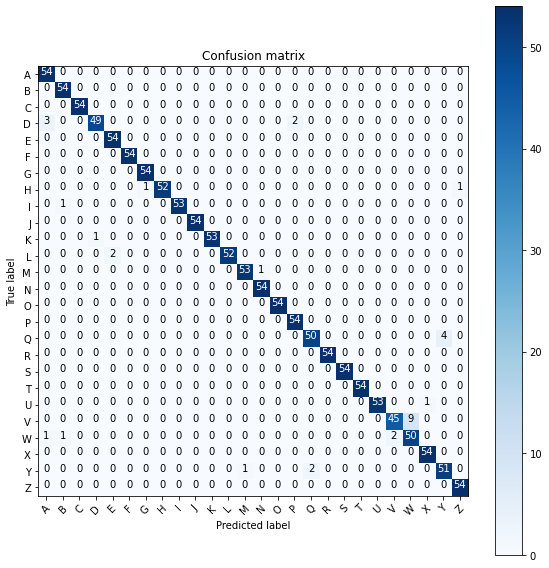

Epoch 1/300
154/154 [==============================] - 20s 90ms/step - loss: 3.1844 - accuracy: 0.0748 - val_loss: 2.3834 - val_accuracy: 0.3077
Epoch 2/300
154/154 [==============================] - 12s 76ms/step - loss: 2.5086 - accuracy: 0.2238 - val_loss: 1.7878 - val_accuracy: 0.4530
Epoch 3/300
154/154 [==============================] - 12s 77ms/step - loss: 2.0218 - accuracy: 0.3375 - val_loss: 1.5010 - val_accuracy: 0.5085
Epoch 4/300
154/154 [==============================] - 12s 77ms/step - loss: 1.7911 - accuracy: 0.4015 - val_loss: 1.3188 - val_accuracy: 0.5627
Epoch 5/300
154/154 [==============================] - 12s 77ms/step - loss: 1.5824 - accuracy: 0.4724 - val_loss: 1.2684 - val_accuracy: 0.5670
Epoch 6/300
154/154 [==============================] - 12s 77ms/step - loss: 1.4347 - accuracy: 0.5041 - val_loss: 1.0319 - val_accuracy: 0.6524
Epoch 7/300
154/154 [==============================] - 12s 77ms/step - loss: 1.3107 - accuracy: 0.5530 - val_loss: 0.9432 - val_ac

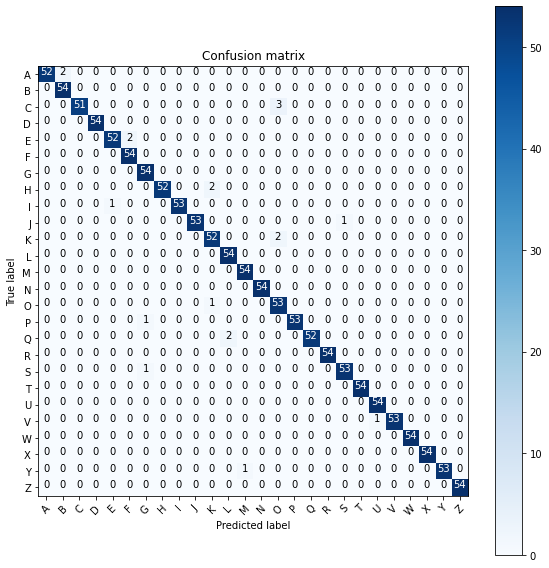

Epoch 1/300
154/154 [==============================] - 20s 88ms/step - loss: 3.1551 - accuracy: 0.0852 - val_loss: 2.3689 - val_accuracy: 0.3732
Epoch 2/300
154/154 [==============================] - 12s 78ms/step - loss: 2.4725 - accuracy: 0.2281 - val_loss: 1.7849 - val_accuracy: 0.4687
Epoch 3/300
154/154 [==============================] - 12s 77ms/step - loss: 2.0093 - accuracy: 0.3377 - val_loss: 1.4941 - val_accuracy: 0.5256
Epoch 4/300
154/154 [==============================] - 12s 78ms/step - loss: 1.7364 - accuracy: 0.4201 - val_loss: 1.2786 - val_accuracy: 0.5940
Epoch 5/300
154/154 [==============================] - 12s 78ms/step - loss: 1.5582 - accuracy: 0.4669 - val_loss: 1.0880 - val_accuracy: 0.6496
Epoch 6/300
154/154 [==============================] - 12s 78ms/step - loss: 1.3809 - accuracy: 0.5325 - val_loss: 1.0866 - val_accuracy: 0.6795
Epoch 7/300
154/154 [==============================] - 12s 78ms/step - loss: 1.2737 - accuracy: 0.5614 - val_loss: 0.9093 - val_ac

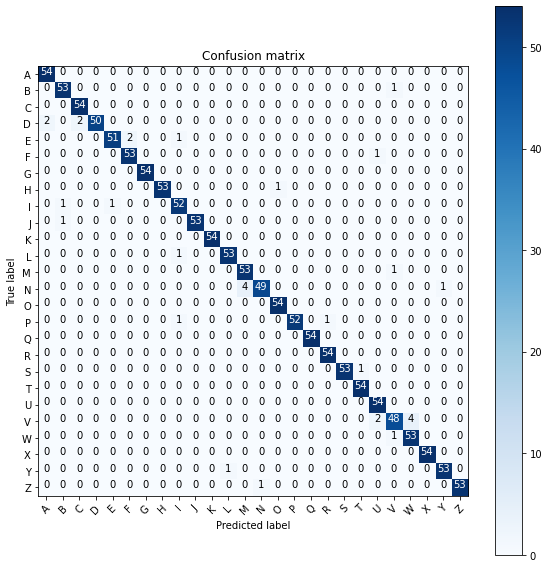

Epoch 1/300
154/154 [==============================] - 20s 88ms/step - loss: 3.1634 - accuracy: 0.0778 - val_loss: 2.4478 - val_accuracy: 0.2977
Epoch 2/300
154/154 [==============================] - 12s 78ms/step - loss: 2.4658 - accuracy: 0.2259 - val_loss: 1.8315 - val_accuracy: 0.4886
Epoch 3/300
154/154 [==============================] - 12s 78ms/step - loss: 2.1591 - accuracy: 0.3102 - val_loss: 1.5174 - val_accuracy: 0.4929
Epoch 4/300
154/154 [==============================] - 12s 78ms/step - loss: 1.7862 - accuracy: 0.4200 - val_loss: 1.4229 - val_accuracy: 0.5385
Epoch 5/300
154/154 [==============================] - 12s 78ms/step - loss: 1.5679 - accuracy: 0.4788 - val_loss: 1.1035 - val_accuracy: 0.6695
Epoch 6/300
154/154 [==============================] - 12s 79ms/step - loss: 1.3992 - accuracy: 0.5438 - val_loss: 0.9612 - val_accuracy: 0.6994
Epoch 7/300
154/154 [==============================] - 12s 79ms/step - loss: 1.2509 - accuracy: 0.5838 - val_loss: 0.8434 - val_ac

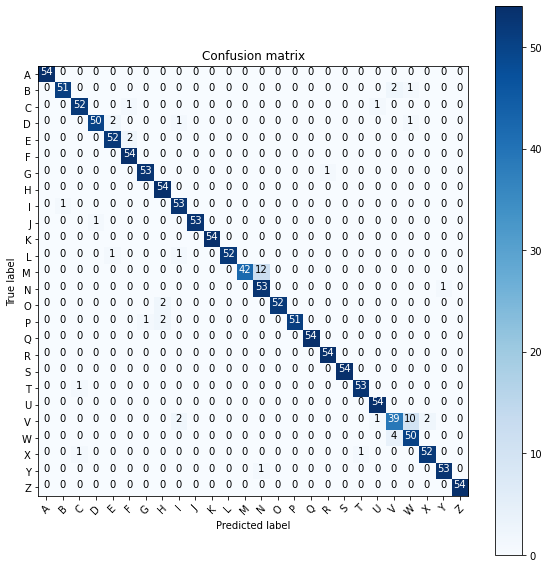

Epoch 1/300
154/154 [==============================] - 20s 92ms/step - loss: 3.1975 - accuracy: 0.0654 - val_loss: 2.5498 - val_accuracy: 0.2991
Epoch 2/300
154/154 [==============================] - 12s 79ms/step - loss: 2.5815 - accuracy: 0.2147 - val_loss: 1.7872 - val_accuracy: 0.4174
Epoch 3/300
154/154 [==============================] - 12s 78ms/step - loss: 2.1127 - accuracy: 0.3193 - val_loss: 1.4030 - val_accuracy: 0.5826
Epoch 4/300
154/154 [==============================] - 12s 78ms/step - loss: 1.8152 - accuracy: 0.3905 - val_loss: 1.2140 - val_accuracy: 0.6282
Epoch 5/300
154/154 [==============================] - 12s 79ms/step - loss: 1.6244 - accuracy: 0.4519 - val_loss: 1.0271 - val_accuracy: 0.6752
Epoch 6/300
154/154 [==============================] - 12s 79ms/step - loss: 1.4245 - accuracy: 0.5105 - val_loss: 0.9213 - val_accuracy: 0.6752
Epoch 7/300
154/154 [==============================] - 12s 80ms/step - loss: 1.3210 - accuracy: 0.5505 - val_loss: 0.7985 - val_ac

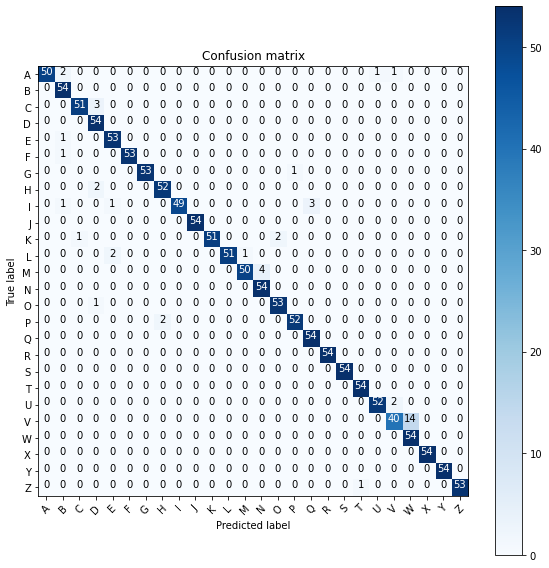

Epoch 1/300
154/154 [==============================] - 21s 90ms/step - loss: 3.1794 - accuracy: 0.0731 - val_loss: 2.5335 - val_accuracy: 0.2934
Epoch 2/300
154/154 [==============================] - 12s 79ms/step - loss: 2.5539 - accuracy: 0.2234 - val_loss: 1.8382 - val_accuracy: 0.4274
Epoch 3/300
154/154 [==============================] - 12s 80ms/step - loss: 2.1003 - accuracy: 0.3212 - val_loss: 1.4975 - val_accuracy: 0.5541
Epoch 4/300
154/154 [==============================] - 12s 80ms/step - loss: 1.8030 - accuracy: 0.3969 - val_loss: 1.2367 - val_accuracy: 0.6496
Epoch 5/300
154/154 [==============================] - 12s 80ms/step - loss: 1.5521 - accuracy: 0.4802 - val_loss: 0.9900 - val_accuracy: 0.7194
Epoch 6/300
154/154 [==============================] - 12s 80ms/step - loss: 1.3389 - accuracy: 0.5471 - val_loss: 0.9952 - val_accuracy: 0.7009
Epoch 7/300
154/154 [==============================] - 12s 80ms/step - loss: 1.3127 - accuracy: 0.5488 - val_loss: 0.8220 - val_ac

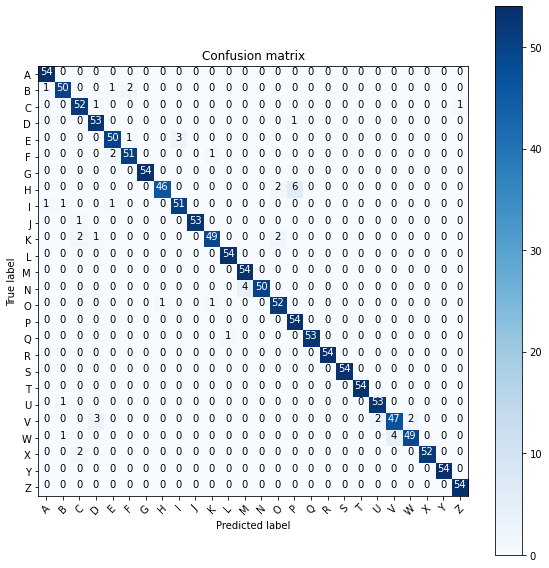

Epoch 1/300
154/154 [==============================] - 20s 91ms/step - loss: 3.1595 - accuracy: 0.0781 - val_loss: 2.3636 - val_accuracy: 0.3575
Epoch 2/300
154/154 [==============================] - 12s 80ms/step - loss: 2.4790 - accuracy: 0.2365 - val_loss: 1.7847 - val_accuracy: 0.4829
Epoch 3/300
154/154 [==============================] - 12s 81ms/step - loss: 2.0406 - accuracy: 0.3338 - val_loss: 1.4070 - val_accuracy: 0.5442
Epoch 4/300
154/154 [==============================] - 12s 81ms/step - loss: 1.7570 - accuracy: 0.4164 - val_loss: 1.2257 - val_accuracy: 0.6168
Epoch 5/300
154/154 [==============================] - 12s 80ms/step - loss: 1.5591 - accuracy: 0.4658 - val_loss: 1.0692 - val_accuracy: 0.6382
Epoch 6/300
154/154 [==============================] - 12s 80ms/step - loss: 1.4074 - accuracy: 0.5248 - val_loss: 0.9309 - val_accuracy: 0.6994
Epoch 7/300
154/154 [==============================] - 12s 80ms/step - loss: 1.2414 - accuracy: 0.5777 - val_loss: 0.7861 - val_ac

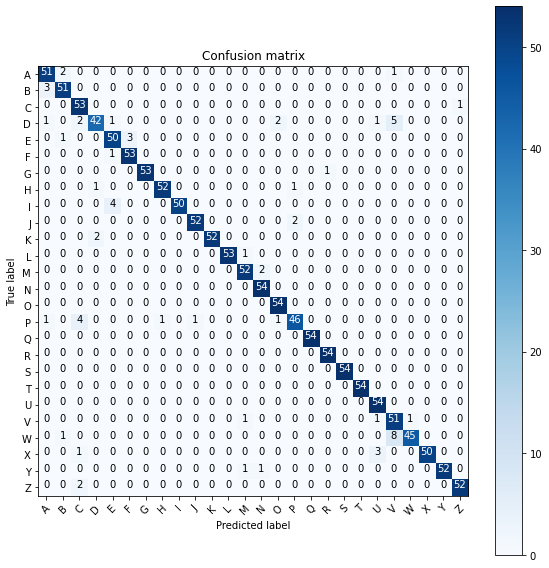

Epoch 1/300
154/154 [==============================] - 20s 94ms/step - loss: 3.1517 - accuracy: 0.0777 - val_loss: 2.4330 - val_accuracy: 0.3120
Epoch 2/300
154/154 [==============================] - 12s 81ms/step - loss: 2.5052 - accuracy: 0.2308 - val_loss: 1.7784 - val_accuracy: 0.4758
Epoch 3/300
154/154 [==============================] - 12s 81ms/step - loss: 2.0337 - accuracy: 0.3391 - val_loss: 1.4409 - val_accuracy: 0.5527
Epoch 4/300
154/154 [==============================] - 12s 81ms/step - loss: 1.7295 - accuracy: 0.4184 - val_loss: 1.3474 - val_accuracy: 0.5798
Epoch 5/300
154/154 [==============================] - 12s 81ms/step - loss: 1.6120 - accuracy: 0.4601 - val_loss: 1.1202 - val_accuracy: 0.6538
Epoch 6/300
154/154 [==============================] - 13s 81ms/step - loss: 1.4581 - accuracy: 0.5046 - val_loss: 1.0065 - val_accuracy: 0.7123
Epoch 7/300
154/154 [==============================] - 12s 81ms/step - loss: 1.3094 - accuracy: 0.5424 - val_loss: 0.9243 - val_ac

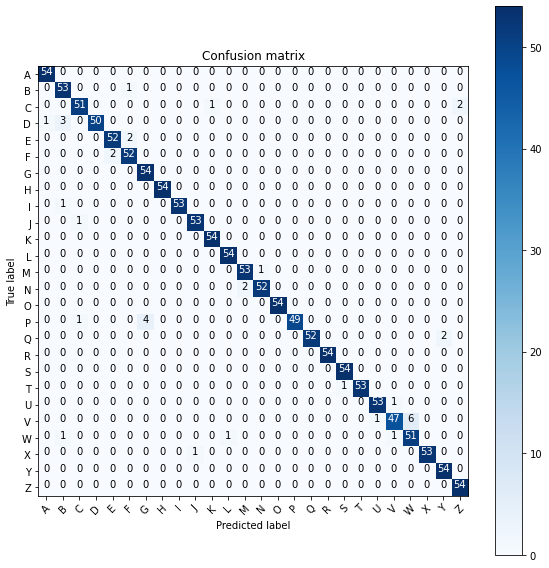

Epoch 1/300
154/154 [==============================] - 20s 93ms/step - loss: 3.1799 - accuracy: 0.0721 - val_loss: 2.4752 - val_accuracy: 0.2977
Epoch 2/300
154/154 [==============================] - 12s 81ms/step - loss: 2.5546 - accuracy: 0.2337 - val_loss: 1.8135 - val_accuracy: 0.4744
Epoch 3/300
154/154 [==============================] - 12s 81ms/step - loss: 2.0767 - accuracy: 0.3286 - val_loss: 1.5128 - val_accuracy: 0.5328
Epoch 4/300
154/154 [==============================] - 12s 81ms/step - loss: 1.7880 - accuracy: 0.4143 - val_loss: 1.2756 - val_accuracy: 0.6197
Epoch 5/300
154/154 [==============================] - 12s 80ms/step - loss: 1.5598 - accuracy: 0.4782 - val_loss: 1.1553 - val_accuracy: 0.6410
Epoch 6/300
154/154 [==============================] - 12s 81ms/step - loss: 1.4194 - accuracy: 0.5073 - val_loss: 1.0504 - val_accuracy: 0.6567
Epoch 7/300
154/154 [==============================] - 12s 81ms/step - loss: 1.2904 - accuracy: 0.5608 - val_loss: 0.9163 - val_ac

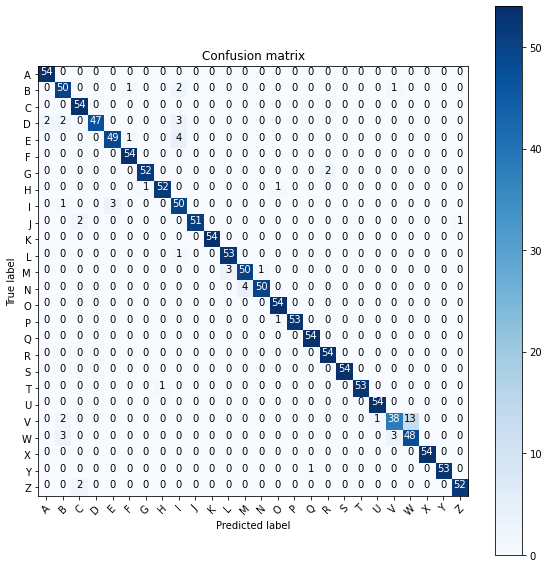

Epoch 1/300
154/154 [==============================] - 21s 92ms/step - loss: 3.1893 - accuracy: 0.0744 - val_loss: 2.5164 - val_accuracy: 0.3319
Epoch 2/300
154/154 [==============================] - 13s 82ms/step - loss: 2.5755 - accuracy: 0.2207 - val_loss: 1.7671 - val_accuracy: 0.4972
Epoch 3/300
154/154 [==============================] - 12s 80ms/step - loss: 2.0848 - accuracy: 0.3349 - val_loss: 1.3804 - val_accuracy: 0.5655
Epoch 4/300
154/154 [==============================] - 13s 82ms/step - loss: 1.7497 - accuracy: 0.4193 - val_loss: 1.3606 - val_accuracy: 0.5755
Epoch 5/300
154/154 [==============================] - 13s 82ms/step - loss: 1.5624 - accuracy: 0.4812 - val_loss: 1.0204 - val_accuracy: 0.6952
Epoch 6/300
154/154 [==============================] - 13s 82ms/step - loss: 1.3788 - accuracy: 0.5522 - val_loss: 0.9778 - val_accuracy: 0.7066
Epoch 7/300
154/154 [==============================] - 13s 82ms/step - loss: 1.2236 - accuracy: 0.5856 - val_loss: 0.8050 - val_ac

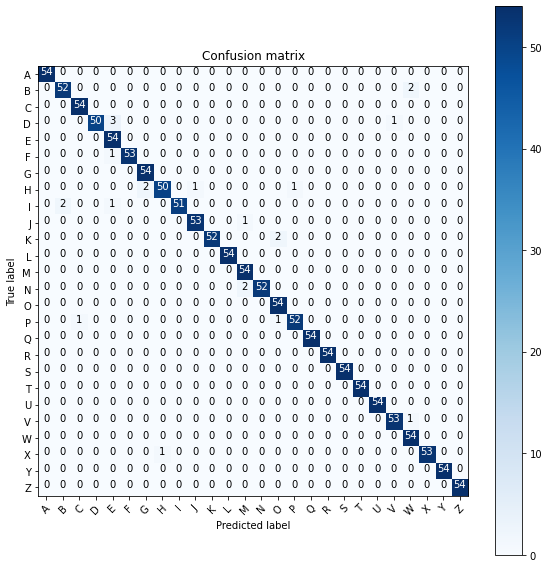

Epoch 1/300
154/154 [==============================] - 21s 92ms/step - loss: 3.1579 - accuracy: 0.0804 - val_loss: 2.5567 - val_accuracy: 0.3219
Epoch 2/300
154/154 [==============================] - 13s 82ms/step - loss: 2.5597 - accuracy: 0.2340 - val_loss: 1.8784 - val_accuracy: 0.4359
Epoch 3/300
154/154 [==============================] - 13s 82ms/step - loss: 2.1433 - accuracy: 0.3113 - val_loss: 1.5173 - val_accuracy: 0.5043
Epoch 4/300
154/154 [==============================] - 13s 81ms/step - loss: 1.7794 - accuracy: 0.4089 - val_loss: 1.2686 - val_accuracy: 0.5726
Epoch 5/300
154/154 [==============================] - 12s 81ms/step - loss: 1.5677 - accuracy: 0.4649 - val_loss: 1.1040 - val_accuracy: 0.6766
Epoch 6/300
154/154 [==============================] - 12s 81ms/step - loss: 1.4267 - accuracy: 0.5062 - val_loss: 1.0060 - val_accuracy: 0.6752
Epoch 7/300
154/154 [==============================] - 12s 80ms/step - loss: 1.2319 - accuracy: 0.5746 - val_loss: 0.8618 - val_ac

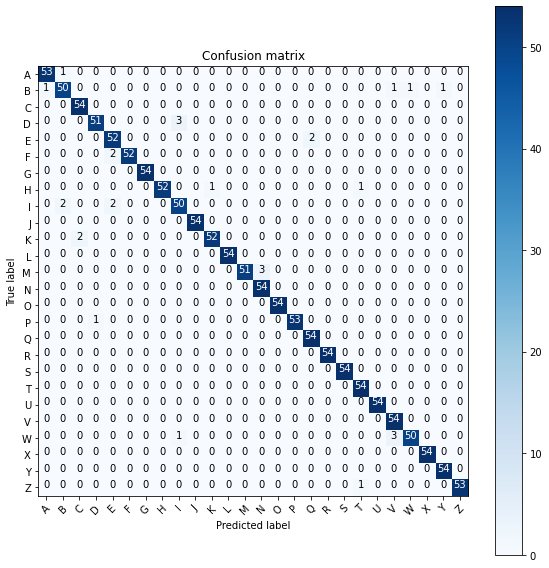

Epoch 1/300
154/154 [==============================] - 21s 92ms/step - loss: 3.1705 - accuracy: 0.0902 - val_loss: 2.4593 - val_accuracy: 0.3134
Epoch 2/300
154/154 [==============================] - 13s 82ms/step - loss: 2.5425 - accuracy: 0.2198 - val_loss: 1.8526 - val_accuracy: 0.4288
Epoch 3/300
154/154 [==============================] - 13s 82ms/step - loss: 2.1050 - accuracy: 0.3122 - val_loss: 1.4390 - val_accuracy: 0.5655
Epoch 4/300
154/154 [==============================] - 13s 82ms/step - loss: 1.7710 - accuracy: 0.3931 - val_loss: 1.2259 - val_accuracy: 0.6154
Epoch 5/300
154/154 [==============================] - 13s 83ms/step - loss: 1.5024 - accuracy: 0.4859 - val_loss: 1.0473 - val_accuracy: 0.6610
Epoch 6/300
154/154 [==============================] - 13s 84ms/step - loss: 1.3734 - accuracy: 0.5140 - val_loss: 0.9238 - val_accuracy: 0.7066
Epoch 7/300
154/154 [==============================] - 13s 82ms/step - loss: 1.2750 - accuracy: 0.5562 - val_loss: 0.8323 - val_ac

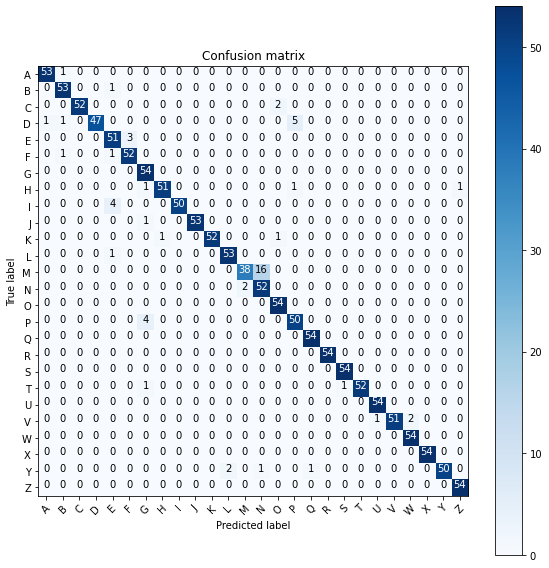

Epoch 1/300
154/154 [==============================] - 21s 92ms/step - loss: 3.1535 - accuracy: 0.0841 - val_loss: 2.4110 - val_accuracy: 0.3248
Epoch 2/300
154/154 [==============================] - 13s 82ms/step - loss: 2.5233 - accuracy: 0.2328 - val_loss: 1.7598 - val_accuracy: 0.4501
Epoch 3/300
154/154 [==============================] - 13s 82ms/step - loss: 2.0600 - accuracy: 0.3236 - val_loss: 1.4779 - val_accuracy: 0.5313
Epoch 4/300
154/154 [==============================] - 13s 81ms/step - loss: 1.8002 - accuracy: 0.3910 - val_loss: 1.3411 - val_accuracy: 0.5499
Epoch 5/300
154/154 [==============================] - 13s 82ms/step - loss: 1.6299 - accuracy: 0.4453 - val_loss: 1.1902 - val_accuracy: 0.6111
Epoch 6/300
154/154 [==============================] - 13s 81ms/step - loss: 1.4161 - accuracy: 0.5095 - val_loss: 0.9824 - val_accuracy: 0.6909
Epoch 7/300
154/154 [==============================] - 13s 82ms/step - loss: 1.2664 - accuracy: 0.5521 - val_loss: 0.8933 - val_ac

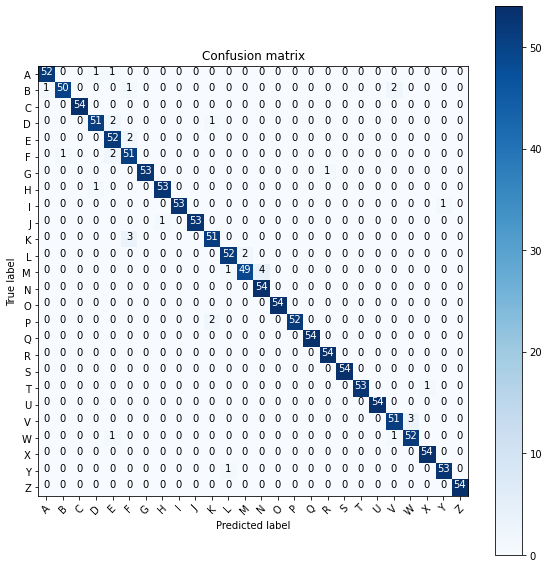

Epoch 1/300
154/154 [==============================] - 21s 98ms/step - loss: 3.1742 - accuracy: 0.0765 - val_loss: 2.4682 - val_accuracy: 0.3348
Epoch 2/300
154/154 [==============================] - 13s 84ms/step - loss: 2.4979 - accuracy: 0.2412 - val_loss: 1.7426 - val_accuracy: 0.4872
Epoch 3/300
154/154 [==============================] - 13s 84ms/step - loss: 2.0511 - accuracy: 0.3385 - val_loss: 1.4191 - val_accuracy: 0.5726
Epoch 4/300
154/154 [==============================] - 13s 83ms/step - loss: 1.7526 - accuracy: 0.4138 - val_loss: 1.2204 - val_accuracy: 0.6396
Epoch 5/300
154/154 [==============================] - 13s 83ms/step - loss: 1.5778 - accuracy: 0.4672 - val_loss: 1.1586 - val_accuracy: 0.6296
Epoch 6/300
154/154 [==============================] - 13s 83ms/step - loss: 1.3803 - accuracy: 0.5279 - val_loss: 0.9870 - val_accuracy: 0.6923
Epoch 7/300
154/154 [==============================] - 13s 84ms/step - loss: 1.2517 - accuracy: 0.5601 - val_loss: 0.8853 - val_ac

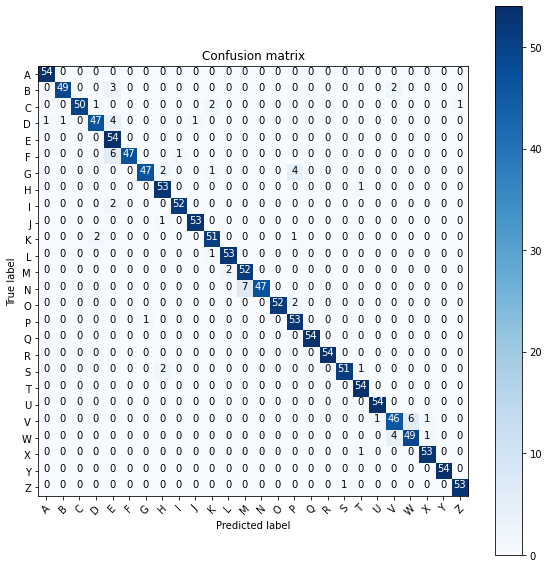

Epoch 1/300
154/154 [==============================] - 21s 95ms/step - loss: 3.1591 - accuracy: 0.0758 - val_loss: 2.3906 - val_accuracy: 0.3447
Epoch 2/300
154/154 [==============================] - 13s 85ms/step - loss: 2.5212 - accuracy: 0.2195 - val_loss: 1.7519 - val_accuracy: 0.4630
Epoch 3/300
154/154 [==============================] - 13s 86ms/step - loss: 2.0410 - accuracy: 0.3388 - val_loss: 1.4272 - val_accuracy: 0.5613
Epoch 4/300
154/154 [==============================] - 13s 83ms/step - loss: 1.7605 - accuracy: 0.4229 - val_loss: 1.1928 - val_accuracy: 0.6311
Epoch 5/300
154/154 [==============================] - 13s 83ms/step - loss: 1.5507 - accuracy: 0.4789 - val_loss: 1.1011 - val_accuracy: 0.6197
Epoch 6/300
154/154 [==============================] - 13s 84ms/step - loss: 1.3819 - accuracy: 0.5259 - val_loss: 1.0279 - val_accuracy: 0.6866
Epoch 7/300
154/154 [==============================] - 13s 84ms/step - loss: 1.2790 - accuracy: 0.5641 - val_loss: 0.7838 - val_ac

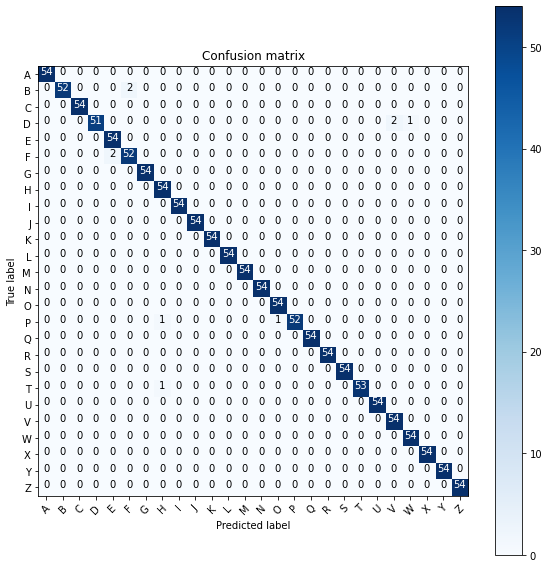

Epoch 1/300
154/154 [==============================] - 21s 96ms/step - loss: 3.2039 - accuracy: 0.0695 - val_loss: 2.6581 - val_accuracy: 0.3219
Epoch 2/300
154/154 [==============================] - 13s 84ms/step - loss: 2.6607 - accuracy: 0.2100 - val_loss: 1.8849 - val_accuracy: 0.4658
Epoch 3/300
154/154 [==============================] - 13s 82ms/step - loss: 2.1461 - accuracy: 0.3189 - val_loss: 1.4930 - val_accuracy: 0.5299
Epoch 4/300
154/154 [==============================] - 13s 84ms/step - loss: 1.7655 - accuracy: 0.4254 - val_loss: 1.2746 - val_accuracy: 0.6111
Epoch 5/300
154/154 [==============================] - 13s 84ms/step - loss: 1.5949 - accuracy: 0.4599 - val_loss: 1.1394 - val_accuracy: 0.6481
Epoch 6/300
154/154 [==============================] - 13s 83ms/step - loss: 1.4300 - accuracy: 0.5156 - val_loss: 1.0238 - val_accuracy: 0.6724
Epoch 7/300
154/154 [==============================] - 13s 83ms/step - loss: 1.2900 - accuracy: 0.5510 - val_loss: 0.8858 - val_ac

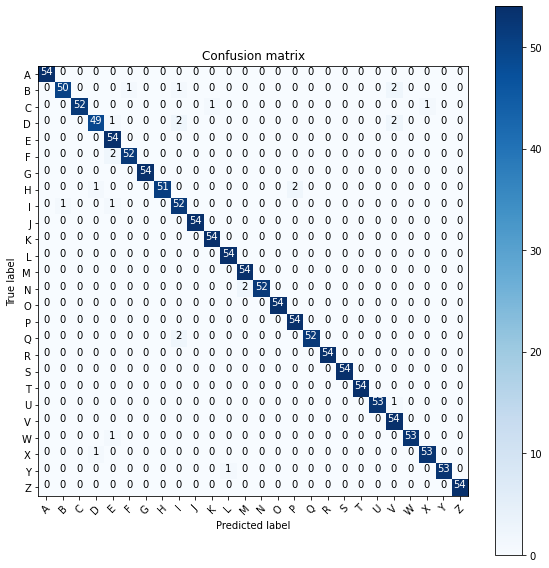

Epoch 1/300
154/154 [==============================] - 21s 96ms/step - loss: 3.1724 - accuracy: 0.0810 - val_loss: 2.5261 - val_accuracy: 0.2991
Epoch 2/300
154/154 [==============================] - 13s 86ms/step - loss: 2.5106 - accuracy: 0.2262 - val_loss: 1.8663 - val_accuracy: 0.4103
Epoch 3/300
154/154 [==============================] - 13s 86ms/step - loss: 2.0530 - accuracy: 0.3359 - val_loss: 1.5194 - val_accuracy: 0.5128
Epoch 4/300
154/154 [==============================] - 13s 86ms/step - loss: 1.7942 - accuracy: 0.4040 - val_loss: 1.3280 - val_accuracy: 0.5698
Epoch 5/300
154/154 [==============================] - 13s 83ms/step - loss: 1.5546 - accuracy: 0.4597 - val_loss: 1.1712 - val_accuracy: 0.6296
Epoch 6/300
154/154 [==============================] - 13s 84ms/step - loss: 1.3854 - accuracy: 0.5185 - val_loss: 1.0386 - val_accuracy: 0.6567
Epoch 7/300
154/154 [==============================] - 13s 86ms/step - loss: 1.2632 - accuracy: 0.5719 - val_loss: 0.8846 - val_ac

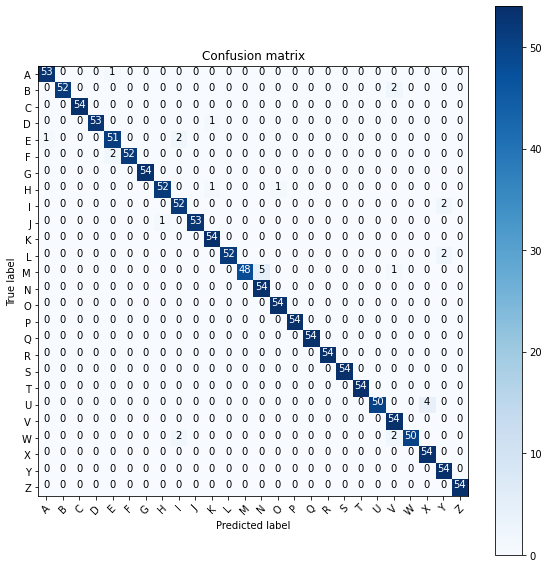

Epoch 1/300
154/154 [==============================] - 21s 96ms/step - loss: 3.1469 - accuracy: 0.0799 - val_loss: 2.4325 - val_accuracy: 0.2650
Epoch 2/300
154/154 [==============================] - 13s 86ms/step - loss: 2.4918 - accuracy: 0.2325 - val_loss: 1.8332 - val_accuracy: 0.4202
Epoch 3/300
154/154 [==============================] - 13s 86ms/step - loss: 2.0569 - accuracy: 0.3153 - val_loss: 1.5341 - val_accuracy: 0.5071
Epoch 4/300
154/154 [==============================] - 13s 85ms/step - loss: 1.7983 - accuracy: 0.4082 - val_loss: 1.2629 - val_accuracy: 0.6111
Epoch 5/300
154/154 [==============================] - 13s 86ms/step - loss: 1.5938 - accuracy: 0.4587 - val_loss: 1.1472 - val_accuracy: 0.6382
Epoch 6/300
154/154 [==============================] - 13s 86ms/step - loss: 1.4350 - accuracy: 0.5029 - val_loss: 0.9756 - val_accuracy: 0.7037
Epoch 7/300
154/154 [==============================] - 13s 87ms/step - loss: 1.2979 - accuracy: 0.5547 - val_loss: 0.8950 - val_ac

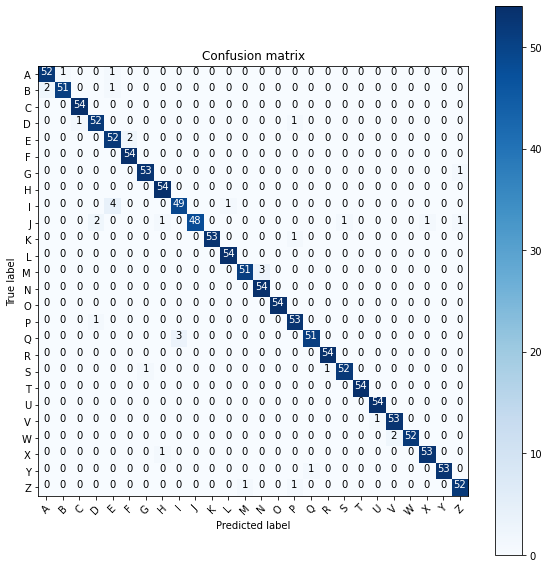

Epoch 1/300
154/154 [==============================] - 21s 94ms/step - loss: 3.1747 - accuracy: 0.0718 - val_loss: 2.4917 - val_accuracy: 0.3291
Epoch 2/300
154/154 [==============================] - 13s 84ms/step - loss: 2.5660 - accuracy: 0.2110 - val_loss: 1.8943 - val_accuracy: 0.4601
Epoch 3/300
154/154 [==============================] - 13s 84ms/step - loss: 2.1256 - accuracy: 0.3074 - val_loss: 1.6091 - val_accuracy: 0.5071
Epoch 4/300
154/154 [==============================] - 13s 84ms/step - loss: 1.8940 - accuracy: 0.3560 - val_loss: 1.3453 - val_accuracy: 0.6154
Epoch 5/300
154/154 [==============================] - 13s 84ms/step - loss: 1.6019 - accuracy: 0.4553 - val_loss: 1.1107 - val_accuracy: 0.6553
Epoch 6/300
154/154 [==============================] - 13s 84ms/step - loss: 1.4171 - accuracy: 0.5028 - val_loss: 0.9781 - val_accuracy: 0.6595
Epoch 7/300
154/154 [==============================] - 13s 84ms/step - loss: 1.3105 - accuracy: 0.5511 - val_loss: 0.8160 - val_ac

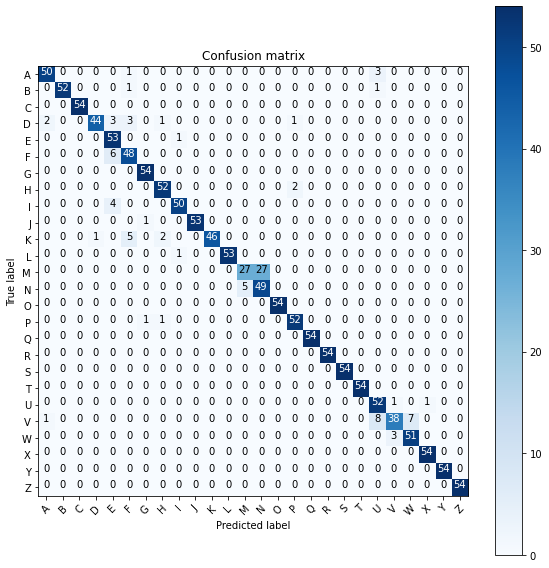

Epoch 1/300
154/154 [==============================] - 22s 98ms/step - loss: 3.1926 - accuracy: 0.0640 - val_loss: 2.5108 - val_accuracy: 0.2934
Epoch 2/300
154/154 [==============================] - 13s 85ms/step - loss: 2.5821 - accuracy: 0.2137 - val_loss: 1.8813 - val_accuracy: 0.4430
Epoch 3/300
154/154 [==============================] - 13s 87ms/step - loss: 2.1182 - accuracy: 0.3231 - val_loss: 1.5043 - val_accuracy: 0.5356
Epoch 4/300
154/154 [==============================] - 14s 88ms/step - loss: 1.8127 - accuracy: 0.4015 - val_loss: 1.2275 - val_accuracy: 0.6011
Epoch 5/300
154/154 [==============================] - 14s 89ms/step - loss: 1.5611 - accuracy: 0.4748 - val_loss: 1.1731 - val_accuracy: 0.5869
Epoch 6/300
154/154 [==============================] - 14s 89ms/step - loss: 1.4506 - accuracy: 0.4979 - val_loss: 0.9676 - val_accuracy: 0.6595
Epoch 7/300
154/154 [==============================] - 13s 87ms/step - loss: 1.2559 - accuracy: 0.5693 - val_loss: 0.9181 - val_ac

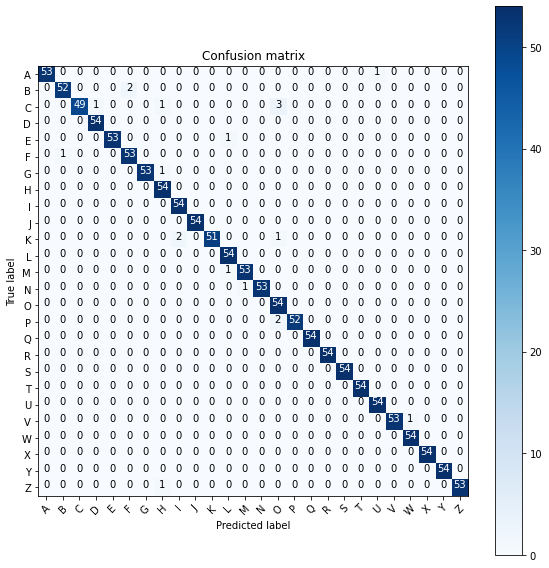

Epoch 1/300
154/154 [==============================] - 21s 97ms/step - loss: 3.1872 - accuracy: 0.0821 - val_loss: 2.5917 - val_accuracy: 0.2792
Epoch 2/300
154/154 [==============================] - 14s 88ms/step - loss: 2.5739 - accuracy: 0.2287 - val_loss: 1.8068 - val_accuracy: 0.4501
Epoch 3/300
154/154 [==============================] - 13s 88ms/step - loss: 2.1077 - accuracy: 0.3171 - val_loss: 1.5054 - val_accuracy: 0.5570
Epoch 4/300
154/154 [==============================] - 14s 88ms/step - loss: 1.8103 - accuracy: 0.4114 - val_loss: 1.3103 - val_accuracy: 0.5897
Epoch 5/300
154/154 [==============================] - 14s 88ms/step - loss: 1.5735 - accuracy: 0.4653 - val_loss: 1.0685 - val_accuracy: 0.6524
Epoch 6/300
154/154 [==============================] - 13s 86ms/step - loss: 1.4326 - accuracy: 0.5185 - val_loss: 0.9655 - val_accuracy: 0.7023
Epoch 7/300
154/154 [==============================] - 14s 88ms/step - loss: 1.2617 - accuracy: 0.5575 - val_loss: 0.8810 - val_ac

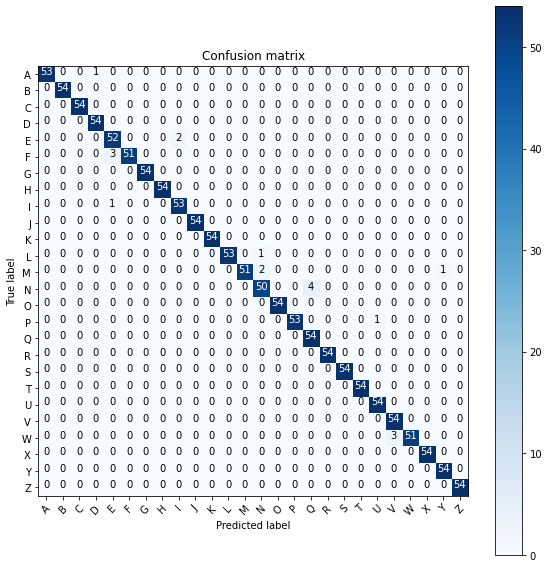

Epoch 1/300
154/154 [==============================] - 22s 99ms/step - loss: 3.1808 - accuracy: 0.0712 - val_loss: 2.4815 - val_accuracy: 0.2721
Epoch 2/300
154/154 [==============================] - 14s 89ms/step - loss: 2.5636 - accuracy: 0.2092 - val_loss: 1.8354 - val_accuracy: 0.4330
Epoch 3/300
154/154 [==============================] - 13s 86ms/step - loss: 2.1802 - accuracy: 0.2997 - val_loss: 1.4572 - val_accuracy: 0.5598
Epoch 4/300
154/154 [==============================] - 13s 86ms/step - loss: 1.7853 - accuracy: 0.4085 - val_loss: 1.2848 - val_accuracy: 0.5783
Epoch 5/300
154/154 [==============================] - 13s 85ms/step - loss: 1.6283 - accuracy: 0.4551 - val_loss: 1.2080 - val_accuracy: 0.6054
Epoch 6/300
154/154 [==============================] - 13s 85ms/step - loss: 1.4234 - accuracy: 0.5175 - val_loss: 0.9668 - val_accuracy: 0.6610
Epoch 7/300
154/154 [==============================] - 13s 85ms/step - loss: 1.3212 - accuracy: 0.5598 - val_loss: 0.8860 - val_ac

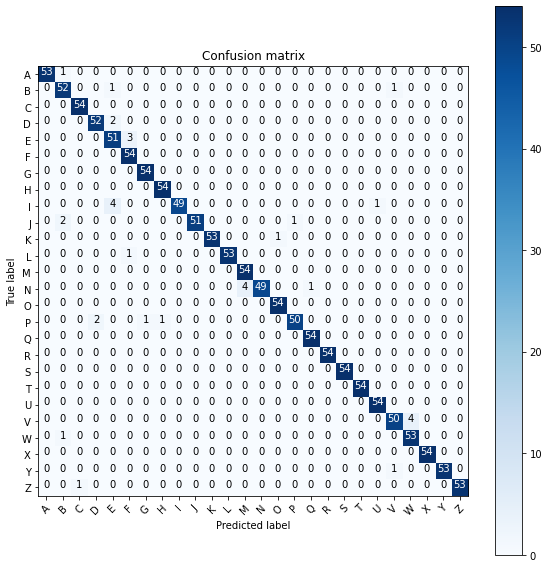

Epoch 1/300
154/154 [==============================] - 21s 98ms/step - loss: 3.1801 - accuracy: 0.0790 - val_loss: 2.5012 - val_accuracy: 0.3006
Epoch 2/300
154/154 [==============================] - 13s 86ms/step - loss: 2.5315 - accuracy: 0.2329 - val_loss: 1.8203 - val_accuracy: 0.4473
Epoch 3/300
154/154 [==============================] - 13s 86ms/step - loss: 2.0819 - accuracy: 0.3368 - val_loss: 1.4554 - val_accuracy: 0.5484
Epoch 4/300
154/154 [==============================] - 13s 85ms/step - loss: 1.8223 - accuracy: 0.3956 - val_loss: 1.2764 - val_accuracy: 0.5897
Epoch 5/300
154/154 [==============================] - 13s 87ms/step - loss: 1.5893 - accuracy: 0.4701 - val_loss: 1.0201 - val_accuracy: 0.6610
Epoch 6/300
154/154 [==============================] - 14s 89ms/step - loss: 1.4219 - accuracy: 0.5291 - val_loss: 0.9332 - val_accuracy: 0.6923
Epoch 7/300
154/154 [==============================] - 14s 89ms/step - loss: 1.2714 - accuracy: 0.5690 - val_loss: 0.8315 - val_ac

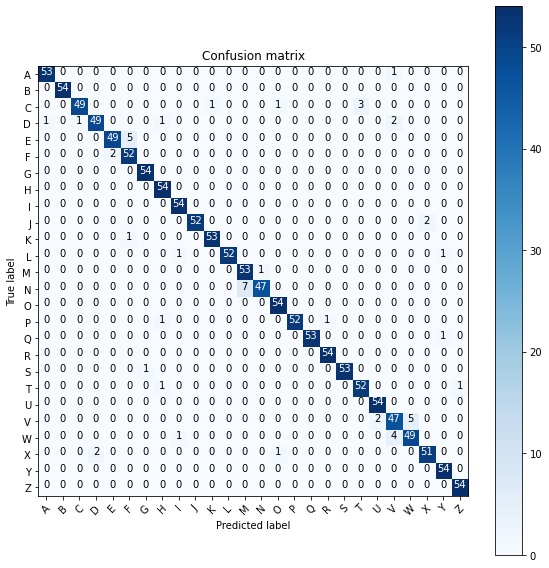

Epoch 1/300
154/154 [==============================] - 21s 99ms/step - loss: 3.1419 - accuracy: 0.0874 - val_loss: 2.3394 - val_accuracy: 0.2963
Epoch 2/300
154/154 [==============================] - 13s 86ms/step - loss: 2.4655 - accuracy: 0.2258 - val_loss: 1.7561 - val_accuracy: 0.4672
Epoch 3/300
154/154 [==============================] - 13s 87ms/step - loss: 2.0174 - accuracy: 0.3540 - val_loss: 1.4312 - val_accuracy: 0.5399
Epoch 4/300
154/154 [==============================] - 13s 86ms/step - loss: 1.7644 - accuracy: 0.4063 - val_loss: 1.2133 - val_accuracy: 0.6068
Epoch 5/300
154/154 [==============================] - 13s 87ms/step - loss: 1.5617 - accuracy: 0.4737 - val_loss: 1.0442 - val_accuracy: 0.6695
Epoch 6/300
154/154 [==============================] - 13s 87ms/step - loss: 1.3881 - accuracy: 0.5278 - val_loss: 0.9121 - val_accuracy: 0.7151
Epoch 7/300
154/154 [==============================] - 13s 86ms/step - loss: 1.2527 - accuracy: 0.5765 - val_loss: 0.8391 - val_ac

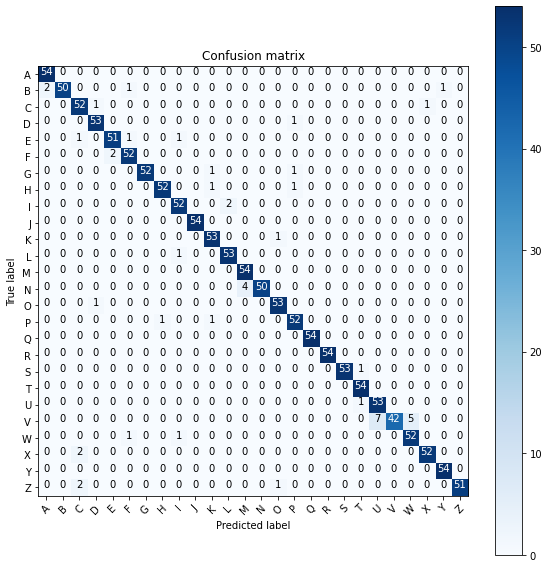

Epoch 1/300
154/154 [==============================] - 21s 96ms/step - loss: 3.1832 - accuracy: 0.0755 - val_loss: 2.4788 - val_accuracy: 0.2849
Epoch 2/300
154/154 [==============================] - 13s 86ms/step - loss: 2.5242 - accuracy: 0.2348 - val_loss: 1.7609 - val_accuracy: 0.5014
Epoch 3/300
154/154 [==============================] - 13s 86ms/step - loss: 2.0325 - accuracy: 0.3497 - val_loss: 1.4045 - val_accuracy: 0.5812
Epoch 4/300
154/154 [==============================] - 13s 86ms/step - loss: 1.7680 - accuracy: 0.4128 - val_loss: 1.1673 - val_accuracy: 0.6353
Epoch 5/300
154/154 [==============================] - 13s 86ms/step - loss: 1.5223 - accuracy: 0.4998 - val_loss: 1.0006 - val_accuracy: 0.6937
Epoch 6/300
154/154 [==============================] - 13s 86ms/step - loss: 1.4121 - accuracy: 0.5186 - val_loss: 0.9412 - val_accuracy: 0.6852
Epoch 7/300
154/154 [==============================] - 13s 86ms/step - loss: 1.2411 - accuracy: 0.5829 - val_loss: 0.7964 - val_ac

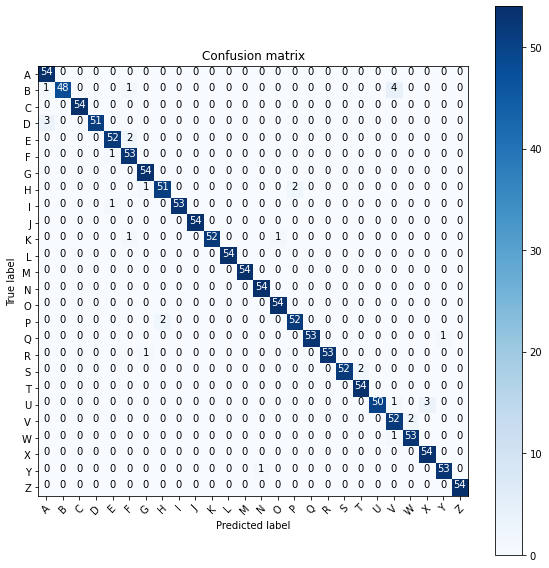

Epoch 1/300
154/154 [==============================] - 21s 97ms/step - loss: 3.1809 - accuracy: 0.0750 - val_loss: 2.5008 - val_accuracy: 0.3020
Epoch 2/300
154/154 [==============================] - 13s 86ms/step - loss: 2.5733 - accuracy: 0.2211 - val_loss: 1.8340 - val_accuracy: 0.4516
Epoch 3/300
154/154 [==============================] - 14s 89ms/step - loss: 2.0915 - accuracy: 0.3230 - val_loss: 1.5108 - val_accuracy: 0.5199
Epoch 4/300
154/154 [==============================] - 14s 90ms/step - loss: 1.8657 - accuracy: 0.3829 - val_loss: 1.2515 - val_accuracy: 0.5940
Epoch 5/300
154/154 [==============================] - 14s 90ms/step - loss: 1.6088 - accuracy: 0.4539 - val_loss: 1.1296 - val_accuracy: 0.6396
Epoch 6/300
154/154 [==============================] - 14s 91ms/step - loss: 1.4901 - accuracy: 0.4997 - val_loss: 1.0078 - val_accuracy: 0.6595
Epoch 7/300
154/154 [==============================] - 14s 90ms/step - loss: 1.3205 - accuracy: 0.5496 - val_loss: 0.8674 - val_ac

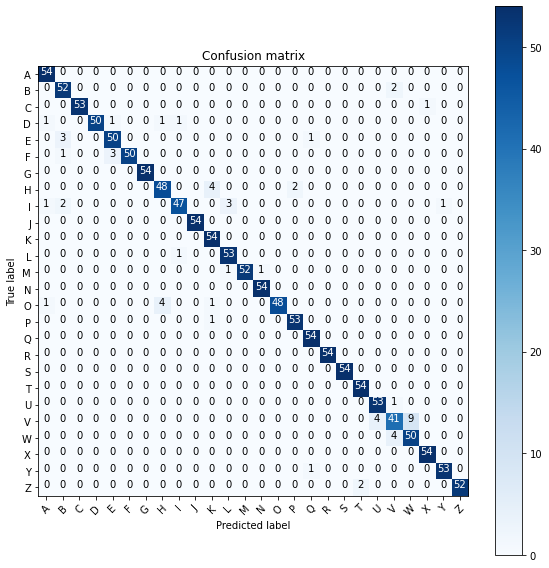

Epoch 1/300
154/154 [==============================] - 22s 103ms/step - loss: 3.1627 - accuracy: 0.0823 - val_loss: 2.4988 - val_accuracy: 0.3661
Epoch 2/300
154/154 [==============================] - 14s 91ms/step - loss: 2.5830 - accuracy: 0.2198 - val_loss: 1.8123 - val_accuracy: 0.5014
Epoch 3/300
154/154 [==============================] - 13s 87ms/step - loss: 2.1211 - accuracy: 0.3231 - val_loss: 1.4208 - val_accuracy: 0.5954
Epoch 4/300
154/154 [==============================] - 13s 87ms/step - loss: 1.8270 - accuracy: 0.3998 - val_loss: 1.1645 - val_accuracy: 0.6467
Epoch 5/300
154/154 [==============================] - 13s 87ms/step - loss: 1.5896 - accuracy: 0.4510 - val_loss: 1.0085 - val_accuracy: 0.6752
Epoch 6/300
154/154 [==============================] - 13s 87ms/step - loss: 1.4561 - accuracy: 0.4980 - val_loss: 0.9188 - val_accuracy: 0.7194
Epoch 7/300
154/154 [==============================] - 14s 91ms/step - loss: 1.2897 - accuracy: 0.5670 - val_loss: 0.8039 - val_a

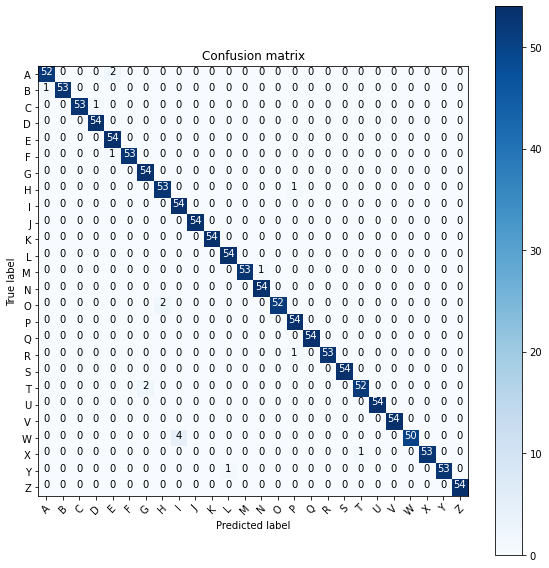

Epoch 1/300
154/154 [==============================] - 23s 107ms/step - loss: 3.1707 - accuracy: 0.0855 - val_loss: 2.4079 - val_accuracy: 0.3205
Epoch 2/300
154/154 [==============================] - 14s 92ms/step - loss: 2.4883 - accuracy: 0.2426 - val_loss: 1.7370 - val_accuracy: 0.4672
Epoch 3/300
154/154 [==============================] - 14s 93ms/step - loss: 2.0322 - accuracy: 0.3384 - val_loss: 1.4086 - val_accuracy: 0.5769
Epoch 4/300
154/154 [==============================] - 14s 92ms/step - loss: 1.7520 - accuracy: 0.4015 - val_loss: 1.2440 - val_accuracy: 0.6111
Epoch 5/300
154/154 [==============================] - 14s 93ms/step - loss: 1.5639 - accuracy: 0.4726 - val_loss: 1.1029 - val_accuracy: 0.6182
Epoch 6/300
154/154 [==============================] - 14s 92ms/step - loss: 1.4282 - accuracy: 0.5235 - val_loss: 1.1015 - val_accuracy: 0.6496
Epoch 7/300
154/154 [==============================] - 14s 92ms/step - loss: 1.2651 - accuracy: 0.5543 - val_loss: 0.9328 - val_a

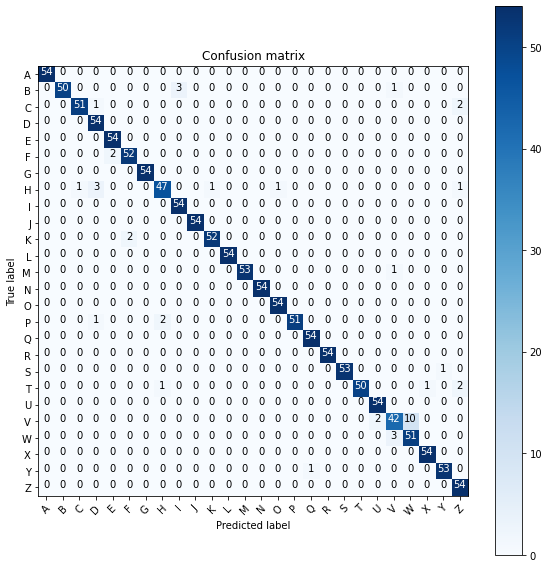

Epoch 1/300
154/154 [==============================] - 22s 103ms/step - loss: 3.1626 - accuracy: 0.0798 - val_loss: 2.4083 - val_accuracy: 0.2920
Epoch 2/300
154/154 [==============================] - 14s 93ms/step - loss: 2.5124 - accuracy: 0.2211 - val_loss: 1.8357 - val_accuracy: 0.4530
Epoch 3/300
154/154 [==============================] - 14s 92ms/step - loss: 2.0230 - accuracy: 0.3413 - val_loss: 1.4825 - val_accuracy: 0.5556
Epoch 4/300
154/154 [==============================] - 14s 92ms/step - loss: 1.7667 - accuracy: 0.4134 - val_loss: 1.2713 - val_accuracy: 0.5954
Epoch 5/300
154/154 [==============================] - 13s 88ms/step - loss: 1.5896 - accuracy: 0.4748 - val_loss: 1.0839 - val_accuracy: 0.6567
Epoch 6/300
154/154 [==============================] - 13s 87ms/step - loss: 1.4132 - accuracy: 0.5144 - val_loss: 0.9746 - val_accuracy: 0.6895
Epoch 7/300
154/154 [==============================] - 14s 88ms/step - loss: 1.2652 - accuracy: 0.5816 - val_loss: 0.9137 - val_a

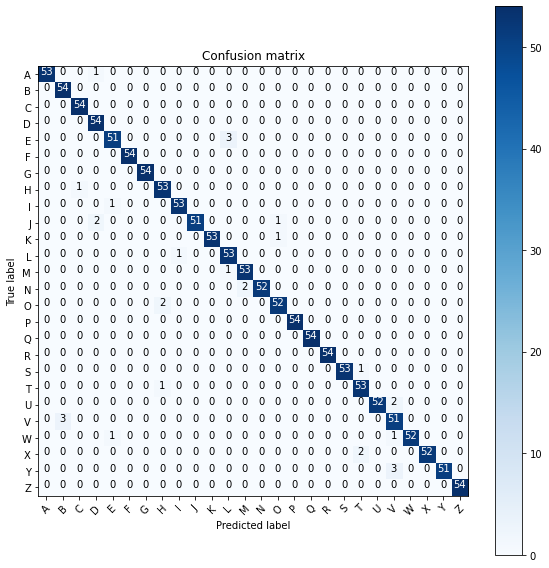

Epoch 1/300
154/154 [==============================] - 21s 97ms/step - loss: 3.1513 - accuracy: 0.0865 - val_loss: 2.4533 - val_accuracy: 0.2877
Epoch 2/300
154/154 [==============================] - 13s 87ms/step - loss: 2.4859 - accuracy: 0.2292 - val_loss: 1.8010 - val_accuracy: 0.4017
Epoch 3/300
154/154 [==============================] - 13s 87ms/step - loss: 2.0557 - accuracy: 0.3260 - val_loss: 1.5275 - val_accuracy: 0.5427
Epoch 4/300
154/154 [==============================] - 13s 87ms/step - loss: 1.7773 - accuracy: 0.3938 - val_loss: 1.2976 - val_accuracy: 0.5912
Epoch 5/300
154/154 [==============================] - 13s 87ms/step - loss: 1.6124 - accuracy: 0.4578 - val_loss: 1.1171 - val_accuracy: 0.6481
Epoch 6/300
154/154 [==============================] - 14s 88ms/step - loss: 1.4075 - accuracy: 0.5148 - val_loss: 1.0128 - val_accuracy: 0.6652
Epoch 7/300
154/154 [==============================] - 14s 88ms/step - loss: 1.2927 - accuracy: 0.5495 - val_loss: 0.8927 - val_ac

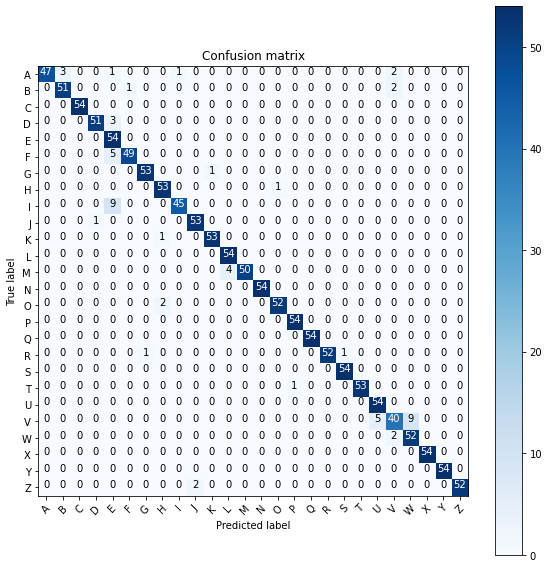

Losses
[[0.08222649]
 [0.06447069]
 [0.08076012]
 [0.15203327]
 [0.1148533 ]
 [0.12743047]
 [0.20384908]
 [0.09898937]
 [0.15390806]
 [0.05901115]
 [0.0785213 ]
 [0.12333728]
 [0.08913069]
 [0.15222278]
 [0.03106987]
 [0.11707317]
 [0.07385992]
 [0.11143702]
 [0.17353112]
 [0.05602922]
 [0.04796631]
 [0.09318577]
 [0.13352786]
 [0.11463862]
 [0.08818718]
 [0.13992919]
 [0.05121309]
 [0.10292444]
 [0.11275949]
 [0.13326909]]
Accuracies
[[0.97649574]
 [0.98575497]
 [0.97720796]
 [0.95940173]
 [0.96652424]
 [0.96225071]
 [0.95299143]
 [0.9736467 ]
 [0.95512819]
 [0.98361826]
 [0.97934473]
 [0.95868945]
 [0.9736467 ]
 [0.95156693]
 [0.99287748]
 [0.98148149]
 [0.97863245]
 [0.97293448]
 [0.93304843]
 [0.98575497]
 [0.98646724]
 [0.97578347]
 [0.96296299]
 [0.96581197]
 [0.97720796]
 [0.95797724]
 [0.98717946]
 [0.96937323]
 [0.97863245]
 [0.95868945]]
Avg loss: 0.10537817993511757 +/- 0.03944029699679564
Avg accuracy: 0.9707027494907379 +/- 0.013175331036269968


In [ ]:
# Experiment 4: training and test on the augmented dataset, 30 random splits
model = BidirectionalLSTMGestureClassifier()
model.runExperiment(dataset_path=AUGMENTED_DATA_DIR, split_number=30, print_report=True)

del model